# UKCI 2021 Analytics

This contains analytics for the 2021 UKCI paper.

Figures to plot:

* show sync vs. asynchronous overall run durations 
* show sync vs. asynchronous by-worker durations for work time vs. idle time
* show best-so-far curves?
* show convergence times?

In [2]:
import pandas as pd
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib notebook

import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon

from analytics import consolidate_csv_as_df, idle_vs_work_times

## First let's snarf up Katies's et al F1TENTH results

In [3]:
cd ../katie_results/new_results/

/Users/may/Projects/async_2021/katie_results/new_results


In [4]:
# First load up the synchronous results
sync_df = consolidate_csv_as_df(Path('.').glob('workers_sync*csv'), infer_run=True)

reading workers_sync_4.csv
Adding run number 4
reading workers_sync_5.csv
Adding run number 5
reading workers_sync_7.csv
Adding run number 7
reading workers_sync_6.csv
Adding run number 6
reading workers_sync_2.csv
Adding run number 2
reading workers_sync_3.csv
Adding run number 3
reading workers_sync_1.csv
Adding run number 1
reading workers_sync_0.csv
Adding run number 0
reading workers_sync_8.csv
Adding run number 8
reading workers_sync_9.csv
Adding run number 9


In [5]:
sync_df['run_type'] = 'sync'

In [6]:
sync_df

step hostname    pid                                  uuid  birth_id  \
0        0   thelio  20474  2ec9caea-7ff6-4fd1-8eca-adf13de9f257         0   
1        0   thelio  20517  857be7fe-6586-445e-a957-a982e66d4a96         1   
2        0   thelio  20487  e2a7e5fe-e558-4dc6-bb2f-e64171c158c0         2   
3        0   thelio  20483  aaf13439-27df-4c41-9c9b-ab15c9699144         3   
4        0   thelio  20506  d1445df3-5510-41cc-8a12-d0ed2dcb811e         4   
...    ...      ...    ...                                   ...       ...   
6055     0   thelio  42924  f42d6b32-ab6a-45bd-b8a7-b5d04ab63e72      6055   
6056     0   thelio  42956  3b54882f-d7c0-4646-875c-1bd8f109edfd      6056   
6057     0   thelio  42943  06e59c2b-c321-4f94-b1bd-e51bf2debca0      6057   
6058     0   thelio  42929  2c0a4b5a-4646-4622-a2a9-48f963780757      6058   
6059     0   thelio  43090  4ccf008d-e906-4476-b734-e4750caae207      6059   

      start_eval_time  stop_eval_time   fitness  run run_type  
0        1.623471e+09    1.623471e+09  0.003517    4     sync  
1        1.623471e+09    1.623471e+09  0.002529    4     sync  
2        1.623471e+09    1.623471e+09  0.002867    4     sync  
3        1.623471e+09    1.623471e+09  0.002830    4     sync  
4        1.623471e+09    1.623471e+09  0.003108    4     sync  
...               ...             ...       ...  ...      ...  
6055     1.623510e+09    1.623510e+09  0.046774    9     sync  
6056     1.623510e+09    1.623510e+09  0.030078    9     sync  
6057     1.623510e+09    1.623510e+09  0.029934    9     sync  
6058     1.623510e+09    1.623510e+09  0.046782    9     sync  
6059     1.623510e+09    1.623510e+09  0.029885    9     sync  

[60600 rows x 10 columns]

In [7]:
sync_df.run.value_counts() # check that the different runs came over ok

9    6060
8    6060
7    6060
6    6060
5    6060
4    6060
3    6060
2    6060
1    6060
0    6060
Name: run, dtype: int64

In [8]:
# Ok, now get the first set of asynchronous results (not with the new eval-select that is the paper's focus)
async_df = consolidate_csv_as_df(Path('.').glob('workers_async_?.csv'), infer_run=True)

reading workers_async_0.csv
Adding run number 0
reading workers_async_1.csv
Adding run number 1
reading workers_async_3.csv
Adding run number 3
reading workers_async_2.csv
Adding run number 2
reading workers_async_6.csv
Adding run number 6
reading workers_async_7.csv
Adding run number 7
reading workers_async_5.csv
Adding run number 5
reading workers_async_4.csv
Adding run number 4
reading workers_async_9.csv
Adding run number 9
reading workers_async_8.csv
Adding run number 8


In [9]:
async_df['run_type'] = 'async'

Now consolidate the two dataframes.

In [10]:
sync_and_async_df = pd.concat([sync_df, async_df])

In [11]:
sync_and_async_df.run_type.value_counts()

sync     60600
async    60000
Name: run_type, dtype: int64

So, the sync runs went one generation more than needed, but that's an easy fix.  We can just drop all the rows that
have a `birth_id > 5999`.

In [12]:
sync_and_async_df = sync_and_async_df[sync_and_async_df.birth_id < 6000]

## Getting the total run evaluation times 

We would normally use the wall clock times, but the runs used the full batch job budget, so that approach is not an option.  (They generally finished before the wall clock time, but the way the various scripts are configured, bash `wait` statements keep the jobs for terminating. There should be a way to refactor those scripts such that the jobs will finish when the last EA puython script finishes, but that will have to await another time.)

So, we want `max(stop_eval_time) - min(start_eval_time)` by `run` and then by `run_type`.

In [13]:
by_run_and_type = sync_and_async_df.groupby(['run_type','run'])

In [14]:
by_run_and_type.birth_id.agg(['count','min','max']) # sanity check to ensure we dropped the right rows

count  min   max
run_type run                  
async    0     6000    0  5999
         1     6000    0  5999
         2     6000    0  5999
         3     6000    0  5999
         4     6000    0  5999
         5     6000    0  5999
         6     6000    0  5999
         7     6000    0  5999
         8     6000    0  5999
         9     6000    0  5999
sync     0     6000    0  5999
         1     6000    0  5999
         2     6000    0  5999
         3     6000    0  5999
         4     6000    0  5999
         5     6000    0  5999
         6     6000    0  5999
         7     6000    0  5999
         8     6000    0  5999
         9     6000    0  5999

In [37]:
run_durations = by_run_and_type.agg({'start_eval_time' : min, 'stop_eval_time' : max, 'fitness' : max})

In [38]:
run_durations # reality check

start_eval_time  stop_eval_time   fitness
run_type run                                           
async    0       1.623440e+09    1.623441e+09  0.032125
         1       1.623452e+09    1.623453e+09  0.025089
         2       1.623456e+09    1.623458e+09  0.053973
         3       1.623463e+09    1.623464e+09  0.025534
         4       1.623470e+09    1.623471e+09  0.034650
         5       1.623474e+09    1.623478e+09  0.066009
         6       1.623483e+09    1.623486e+09  0.057265
         7       1.623489e+09    1.623491e+09  0.047831
         8       1.623495e+09    1.623497e+09  0.031975
         9       1.623503e+09    1.623506e+09  0.069066
sync     0       1.623441e+09    1.623444e+09  0.050747
         1       1.623453e+09    1.623455e+09  0.020061
         2       1.623458e+09    1.623460e+09  0.023673
         3       1.623464e+09    1.623468e+09  0.051448
         4       1.623471e+09    1.623473e+09  0.026039
         5       1.623478e+09    1.623482e+09  0.032328
         6       1.623486e+09    1.623488e+09  0.033320
         7       1.623491e+09    1.623494e+09  0.022752
         8       1.623497e+09    1.623501e+09  0.044895
         9       1.623506e+09    1.623510e+09  0.048544

In [18]:
run_durations['duration_secs'] = run_durations['stop_eval_time'] - run_durations['start_eval_time']

In [19]:
run_durations['duration_hrs'] = run_durations['duration_secs'] / 60 / 60

<IPython.core.display.Javascript object>


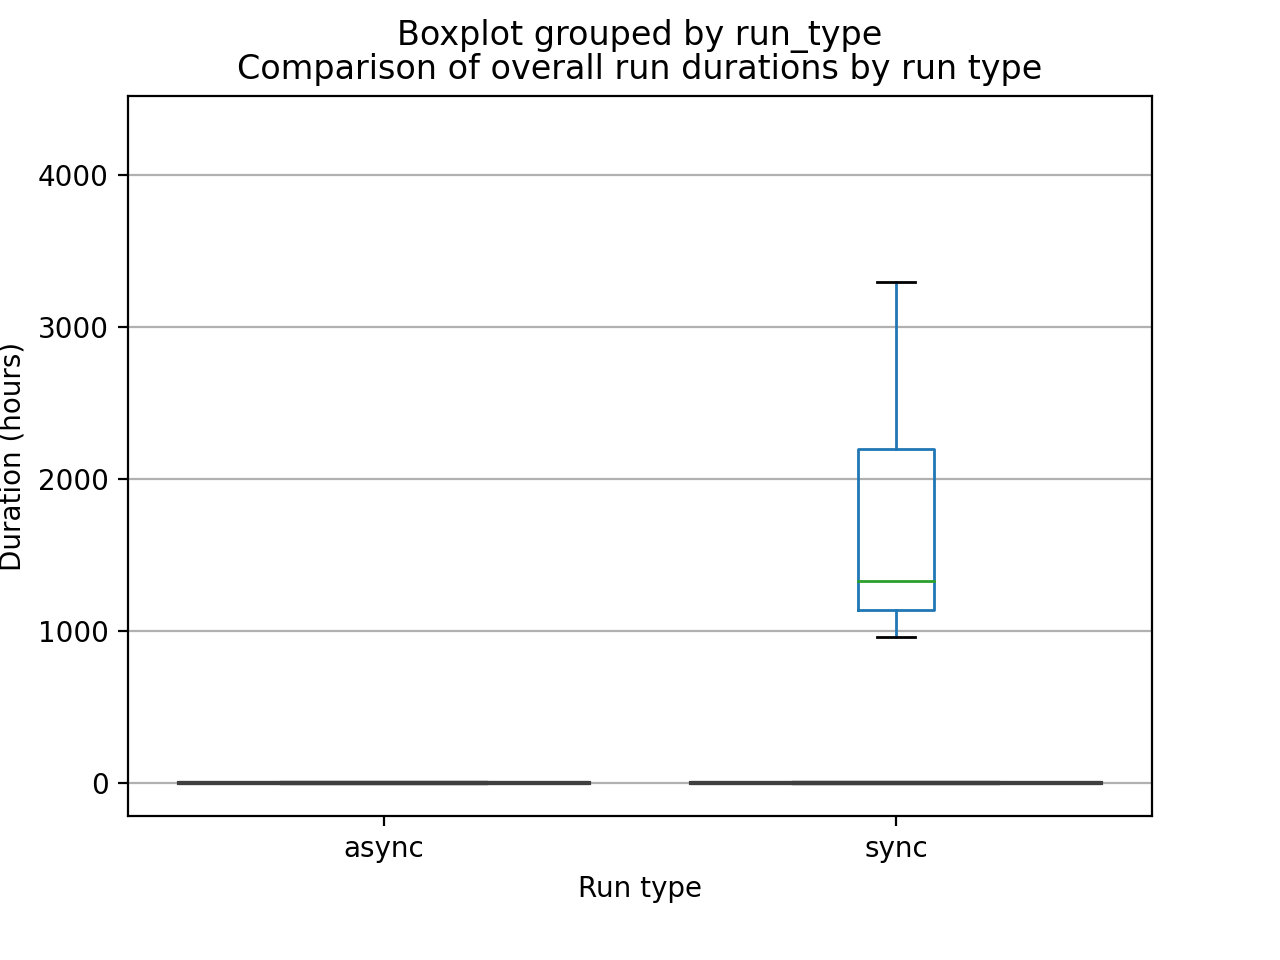

In [20]:
run_durations.boxplot(column=['duration_secs'], by='run_type')

In [21]:
new_run_durations = run_durations.reset_index(drop=False)

In [22]:
new_run_durations

run_type  run  start_eval_time  stop_eval_time  duration_secs  duration_hrs
0     async    0     1.623440e+09    1.623441e+09    1211.393948      0.336498
1     async    1     1.623452e+09    1.623453e+09     963.090203      0.267525
2     async    2     1.623456e+09    1.623458e+09    1689.128730      0.469202
3     async    3     1.623463e+09    1.623464e+09    1105.275345      0.307021
4     async    4     1.623470e+09    1.623471e+09    1303.128894      0.361980
5     async    5     1.623474e+09    1.623478e+09    3296.653492      0.915737
6     async    6     1.623483e+09    1.623486e+09    2368.539962      0.657928
7     async    7     1.623489e+09    1.623491e+09    1354.180879      0.376161
8     async    8     1.623495e+09    1.623497e+09    1115.336529      0.309816
9     async    9     1.623503e+09    1.623506e+09    2846.524728      0.790701
10     sync    0     1.623441e+09    1.623444e+09    3487.395465      0.968721
11     sync    1     1.623453e+09    1.623455e+09    1776.428864      0.493452
12     sync    2     1.623458e+09    1.623460e+09    2181.442532      0.605956
13     sync    3     1.623464e+09    1.623468e+09    3856.285271      1.071190
14     sync    4     1.623471e+09    1.623473e+09    1860.533807      0.516815
15     sync    5     1.623478e+09    1.623482e+09    4082.965169      1.134157
16     sync    6     1.623486e+09    1.623488e+09    2518.978447      0.699716
17     sync    7     1.623491e+09    1.623494e+09    2944.412959      0.817892
18     sync    8     1.623497e+09    1.623501e+09    4306.641979      1.196289
19     sync    9     1.623506e+09    1.623510e+09    3918.343929      1.088429

In [23]:
bp = sns.boxplot(x='run_type', y='duration_hrs', data=new_run_durations)

In [24]:
bp.axes.set_title('Comparison of overall run durations by run type')

Text(0.5, 1.0, 'Comparison of overall run durations by run type')

In [25]:
bp.set_xlabel('Run type')

Text(0.5, 85.44444444444447, 'Run type')

In [26]:
bp.set_ylabel('Duration (hours)')

Text(26.444444444444446, 0.5, 'Duration (hours)')

In [27]:
bp.figure.savefig('f1tenth-durations.pdf')

In [28]:
sync_durations = new_run_durations[new_run_durations.run_type == 'sync'].duration_hrs

In [29]:
async_durations = new_run_durations[new_run_durations.run_type == 'async'].duration_hrs

In [30]:
wilcoxon(sync_durations, async_durations, alternative='greater')

WilcoxonResult(statistic=55.0, pvalue=0.002531016063133932)

## Finding when we get the best answer

The crux of the paper is that we get better answers sooner by allowing for selecting parents from the population *and* evaluating individuals.  So, for each run we need to figure out when we got `max(fitness)`, and we then use that to
calculate how far into the run that happened by run type.

We need to do the following:

1. Find `min(start_eval_time)` because that will be the baseline from when the run starts
2. Find _when_ we found `max(fitness)` for each run
3. Subtract that time from the overall `min(start_eval_time)` found in the first step to find the offset, in seconds, that we found the best solution.
4. Then we can do a pretty box plot showing that offset by run type
5. And, finally, we can say something statistically via Wilcoxon rank-sum

In [35]:
by_run_and_type.head()

step hostname     pid                                  uuid  birth_id  \
0    0.0   thelio   20474  2ec9caea-7ff6-4fd1-8eca-adf13de9f257         0   
1    0.0   thelio   20517  857be7fe-6586-445e-a957-a982e66d4a96         1   
2    0.0   thelio   20487  e2a7e5fe-e558-4dc6-bb2f-e64171c158c0         2   
3    0.0   thelio   20483  aaf13439-27df-4c41-9c9b-ab15c9699144         3   
4    0.0   thelio   20506  d1445df3-5510-41cc-8a12-d0ed2dcb811e         4   
..   ...      ...     ...                                   ...       ...   
0    NaN   thelio  128840  6540124c-f51b-4736-8e04-90142f1fa4b7        14   
1    NaN   thelio  128840  f3835c1a-c1de-4b2a-82bd-6713f269d16d        46   
2    NaN   thelio  128868  46135e2c-0ce6-4e4a-84fe-6da4dc37bc7d        13   
3    NaN   thelio  128843  1e417d64-0980-4cec-a22c-06e792c733fa        44   
4    NaN   thelio  128871  70095550-6d75-45f7-bc8d-8ef11b3e02ff        31   

    start_eval_time  stop_eval_time   fitness  run run_type     worker_id  
0      1.623471e+09    1.623471e+09  0.003517    4     sync   thelio20474  
1      1.623471e+09    1.623471e+09  0.002529    4     sync   thelio20517  
2      1.623471e+09    1.623471e+09  0.002867    4     sync   thelio20487  
3      1.623471e+09    1.623471e+09  0.002830    4     sync   thelio20483  
4      1.623471e+09    1.623471e+09  0.003108    4     sync   thelio20506  
..              ...             ...       ...  ...      ...           ...  
0      1.623495e+09    1.623495e+09  0.002524    8    async  thelio128840  
1      1.623495e+09    1.623495e+09  0.003588    8    async  thelio128840  
2      1.623495e+09    1.623495e+09  0.002131    8    async  thelio128868  
3      1.623495e+09    1.623495e+09  0.002605    8    async  thelio128843  
4      1.623495e+09    1.623495e+09  0.002120    8    async  thelio128871  

[100 rows x 11 columns]

## Getting work vs. idle times by run type

Each dask worker has an UUID, but we don't capture that, so we have to rely on concatenating the hostname and process ID (pid) to make a unique identifier that we'll later group by.

Had to abandon this since the workers were using threading, so we cannot tease out what *thread* did what.  So, in the future, we hope to repeat these experiments, but this time specify to use subprocesses and not threading.

In [31]:
sync_vs_async_times_df = idle_vs_work_times(sync_and_async_df)

thelio100772
1623489366.1018062 1623489373.6551585
1623489366.1452394 1623489375.2636206
1623489366.1305814 1623489375.7073412
1623489366.1121616 1623489375.7233775
1623489373.6802778 1623489378.0177095
1623489375.7536874 1623489379.2201867
1623489378.8267622 1623489381.246948
1623489379.9385984 1623489382.8580306
1623489381.9131978 1623489385.6139257
1623489383.4019554 1623489386.5730908
1623489386.7538402 1623489388.6677635
1623489388.9203875 1623489391.5011573
1623489391.5457098 1623489394.0805476
1623489392.373038 1623489395.175984
1623489395.4225 1623489397.7237625
1623489400.277697 1623489403.2463071
1623489397.8442633 1623489403.5949929
1623489403.6473846 1623489406.5417366
1623489406.6715693 1623489408.983368
1623489409.2570186 1623489411.3119154
1623489411.3848047 1623489413.9940937
1623489414.1008234 1623489417.5228534
1623489415.0540154 1623489420.1682491
1623489417.712795 1623489421.810627
1623489421.9275036 1623489424.0764358
1623489423.900135 1623489427.0408225
1623489424

1623489812.968238 1623489824.2205145
1623489820.1787038 1623489828.1625993
1623489820.1177099 1623489828.2859044
1623489824.4932306 1623489832.5480108
1623489824.353886 1623489833.7531095
1623489828.4123359 1623489839.4437685
1623489828.3636749 1623489840.9520586
1623489833.9174516 1623489842.6600955
1623489837.2778096 1623489845.364916
1623489841.0529525 1623489846.8805652
1623489842.7765565 1623489848.6845493
1623489845.6218958 1623489851.5195904
1623489848.9365911 1623489854.3076313
1623489847.1390648 1623489856.046692
1623489854.346541 1623489859.2944398
1623489851.6884985 1623489860.0104954
1623489856.3541305 1623489861.1249769
1623489859.7307975 1623489864.225497
1623489861.171559 1623489867.7566993
1623489860.121582 1623489870.34895
1623489861.2998984 1623489871.8118634
1623489872.1742694 1623489885.5069735
1623489867.8391626 1623489886.5247586
1623489867.9608858 1623489887.5175953
1623489875.6978679 1623489888.5521238
1623489886.8264196 1623489892.519626
1623489888.6036813 1623

1623489726.1066928 1623489745.397238
1623489733.738709 1623489746.694409
1623489734.4174926 1623489748.2396455
1623489735.1372569 1623489748.3219776
1623489747.520464 1623489755.8758698
1623489748.5235484 1623489756.1906533
1623489748.3842616 1623489758.062311
1623489756.5293207 1623489767.9675345
1623489756.2205822 1623489768.8484983
1623489756.0718734 1623489769.0808134
1623489756.7143855 1623489769.9049325
1623489770.102874 1623489774.409701
1623489769.365908 1623489777.423419
1623489768.98537 1623489777.4846807
1623489777.6281574 1623489782.2603931
1623489774.8548827 1623489783.2959695
1623489777.511543 1623489786.4640267
1623489782.381624 1623489791.5608492
1623489783.5340605 1623489794.5281296
1623489783.364665 1623489794.6520472
1623489791.7161195 1623489797.4952714
1623489794.7691765 1623489798.7625852
1623489791.5909052 1623489800.580121
1623489797.5084069 1623489809.1568909
1623489800.834312 1623489811.3885741
1623489798.919677 1623489811.4055114
1623489800.7656467 1623489812

1623489626.6214144 1623489630.7186878
1623489630.8339822 1623489636.0556743
1623489631.1511886 1623489636.8596635
1623489637.0832605 1623489640.0248766
1623489640.0730126 1623489644.5606456
1623489640.7006087 1623489644.892443
1623489644.6195164 1623489647.9483268
1623489645.563402 1623489649.7186673
1623489648.7090724 1623489652.1653304
1623489652.5256865 1623489656.4446185
1623489649.777912 1623489657.6200635
1623489656.6230664 1623489660.318056
1623489657.7812176 1623489661.929694
1623489660.6678052 1623489663.9611766
1623489662.1502373 1623489668.696057
1623489662.268445 1623489673.298277
1623489664.178517 1623489675.042652
1623489668.722847 1623489676.8265007
1623489669.1046462 1623489677.3553257
1623489675.11344 1623489683.9611342
1623489676.1803982 1623489685.5105276
1623489677.0687346 1623489688.842558
1623489677.3941927 1623489689.8846636
1623489685.0841744 1623489691.5486743
1623489689.3727002 1623489702.2988913
1623489691.5488842 1623489704.6846714
1623489691.6847842 1623489

1623491448.092292 1623491480.9437
1623491448.1020494 1623491480.9465961
1623491448.10737 1623491479.3174276
1623491485.1120615 1623491505.2801108
1623491485.1171696 1623491502.91391
1623491485.1274545 1623491505.4257312
1623491485.137391 1623491504.3966
1623491510.3656466 1623491524.8048975
1623491510.3739586 1623491526.3648574
1623491510.3808115 1623491521.8942196
1623491510.3885994 1623491524.1388993
1623491542.1196465 1623491551.2500048
1623491542.129785 1623491559.4860866
1623491542.1398165 1623491551.3174734
1623491542.1468608 1623491559.791095
1623491578.4119446 1623491597.9515555
1623491578.41858 1623491590.2691545
1623491578.4270866 1623491597.6127458
1623491578.436351 1623491598.1568954
1623491605.0355105 1623491621.5822196
1623491605.0405896 1623491622.0383258
1623491605.0510778 1623491625.230068
1623491605.0608315 1623491625.3898358
1623491635.1153164 1623491662.5126688
1623491635.125183 1623491662.4767756
1623491635.130266 1623491649.7390964
1623491635.1387975 1623491662.16

1623491312.0399914 1623491331.8992445
1623491312.0451472 1623491333.8007245
1623491338.0206337 1623491352.413154
1623491338.0297794 1623491354.9286509
1623491338.0348382 1623491353.481562
1623491338.045054 1623491353.5563455
1623491360.8288553 1623491391.704423
1623491360.83876 1623491392.353256
1623491360.8438578 1623491389.1650488
1623491360.8590472 1623491392.3277605
1623491397.4792635 1623491420.3482585
1623491397.4898696 1623491419.2009506
1623491397.4949439 1623491414.964158
1623491397.500258 1623491420.1098905
1623491423.562885 1623491440.7523475
1623491423.5690136 1623491439.263364
1623491423.57413 1623491438.2256098
1623491423.5831227 1623491438.919756
1623491448.0836165 1623491456.627331
1623491448.0887527 1623491472.918864
1623491448.094054 1623491473.3986256
1623491448.0990953 1623491473.4247801
1623491485.2531006 1623491504.6168294
1623491485.2583122 1623491506.7760038
1623491485.263666 1623491506.7507114
1623491485.2735946 1623491505.4852734
1623491510.3681185 1623491530.

1623490818.6240358 1623490828.8258545
1623490838.7685544 1623490846.7438436
1623490838.7749367 1623490847.4275846
1623490838.7850964 1623490847.9746325
1623490838.7902153 1623490847.089717
1623490857.1209974 1623490865.4716086
1623490857.1281312 1623490866.9728675
1623490857.13617 1623490865.9459574
1623490857.1509712 1623490866.8976967
1623490874.2055519 1623490893.7978315
1623490874.2106373 1623490893.822657
1623490874.2261686 1623490884.9260056
1623490874.2432973 1623490884.7598786
1623490903.7067244 1623490917.3386865
1623490903.7164779 1623490919.1992831
1623490903.7219136 1623490914.3387852
1623490903.7297387 1623490919.1142507
1623490928.9945385 1623490939.0797222
1623490929.0045753 1623490941.5971148
1623490929.0167189 1623490941.4323869
1623490929.0218544 1623490941.5906448
1623490946.1782858 1623490955.8976905
1623490946.1833932 1623490964.1916096
1623490946.1934154 1623490955.6039019
1623490946.2142575 1623490964.5020552
1623490981.8955936 1623490989.996592
1623490981.902115

1623492893.4124262 1623492907.584065
1623492923.2667792 1623492950.757344
1623492923.2767305 1623492950.867351
1623492923.2921164 1623492950.5427518
1623492923.3022795 1623492949.4878035
1623492956.2502322 1623492983.169966
1623492956.2553287 1623492972.6683495
1623492956.260656 1623492983.0433936
1623492956.2657695 1623492983.4052715
1623492993.829513 1623493018.7293186
1623492993.8346071 1623493018.103942
1623492993.8398848 1623493016.8019927
1623492993.8726525 1623493019.9548414
1623493024.0824752 1623493052.7032127
1623493024.0918918 1623493052.595844
1623493024.0969553 1623493052.7630348
1623493024.1178632 1623493052.8254726
1623493057.4536471 1623493066.1627376
1623493057.4617984 1623493066.5501904
1623493057.4699507 1623493069.945325
1623493057.4799886 1623493066.685768
1623493093.0494895 1623493108.1275966
1623493093.05723 1623493105.7705376
1623493093.0646248 1623493104.4262805
1623493093.069701 1623493107.9572926
1623493124.9919868 1623493153.3400018
1623493124.9970536 162349

1623463573.8041143 1623463587.4639587
1623463574.8759346 1623463588.1172216
1623463582.7733636 1623463591.6035554
1623463584.7399645 1623463597.2150471
1623463588.2484784 1623463600.350365
1623463588.5188565 1623463600.452103
1623463597.4592896 1623463605.4421735
1623463600.5115385 1623463608.1786585
1623463602.1440566 1623463608.5095837
1623463597.5131533 1623463611.4618096
1623463608.3054368 1623463615.3083131
1623463608.7490926 1623463617.136345
1623463608.6885257 1623463622.5985653
1623463615.4529006 1623463622.8411589
1623463612.1472466 1623463624.5287654
1623463622.876475 1623463628.5221126
1623463622.7293801 1623463629.7464442
1623463623.1584446 1623463633.7095735
1623463628.6509836 1623463639.326848
1623463629.8672554 1623463640.4129562
1623463633.8797994 1623463640.6426394
1623463634.4599226 1623463642.389889
1623463640.5450413 1623463654.6948905
1623463640.8231015 1623463654.7355769
1623463640.4390495 1623463654.9037256
1623463645.9517667 1623463659.2949214
1623463655.1102958

1623463013.8786964 1623463020.093452
1623463014.3730922 1623463022.4497154
1623463017.7065547 1623463023.749534
1623463020.252976 1623463027.1234255
1623463023.1708019 1623463029.3328786
1623463027.169268 1623463032.130188
1623463029.6117868 1623463032.7442036
1623463033.0415785 1623463035.1755855
1623463034.5590596 1623463037.2704985
1623463035.207256 1623463038.0874598
1623463037.3481715 1623463043.5232825
1623463038.1560988 1623463044.1863108
1623463043.6724296 1623463048.5777931
1623463044.6240385 1623463049.9806206
1623463048.9796848 1623463053.2819874
1623463049.6732962 1623463054.5519645
1623463053.4628565 1623463056.4694927
1623463054.7049274 1623463058.734086
1623463056.751416 1623463060.0856595
1623463059.45657 1623463065.6823006
1623463060.3342855 1623463067.7671561
1623463067.7910323 1623463071.7816062
1623463065.8068616 1623463072.5006926
1623463069.403576 1623463078.573906
1623463072.3119395 1623463083.668037
1623463073.3391116 1623463087.0991712
1623463075.79205 16234630

1623463545.3340902 1623463559.4773364
1623463546.6261716 1623463563.4185088
1623463547.7827694 1623463564.253609
1623463552.3974366 1623463567.2820005
1623463563.5760596 1623463570.3526404
1623463559.6144273 1623463571.876987
1623463567.3781607 1623463577.9039965
1623463568.7081976 1623463582.281665
1623463572.2212894 1623463585.6309671
1623463571.9598892 1623463586.0174248
1623463578.4749556 1623463586.7080455
1623463582.638196 1623463590.2314165
1623463587.2898054 1623463594.7517214
1623463586.7788644 1623463599.4127858
1623463586.4222395 1623463600.6138785
1623463591.8494596 1623463606.2853782
1623463595.3646905 1623463608.4808874
1623463600.7310948 1623463608.8286786
1623463601.6524613 1623463616.1285276
1623463608.8654854 1623463616.6113842
1623463607.3761258 1623463621.4860153
1623463609.403021 1623463624.1393945
1623463616.496891 1623463624.8136814
1623463618.1064231 1623463626.0149431
1623463624.9112198 1623463632.8222494
1623463621.8094945 1623463634.2345574
1623463625.9457495

1623463944.0548606 1623463950.6411285
1623463947.3944392 1623463952.8984392
1623463945.7608588 1623463953.463436
1623463953.5624194 1623463956.8516493
1623463954.5017414 1623463957.5684009
1623463957.6737998 1623463960.0570874
1623463960.206362 1623463964.3623946
1623463960.1026902 1623463964.4248085
1623463964.5033493 1623463967.0226672
1623463967.1573193 1623463970.9641075
1623463967.2616982 1623463972.108463
1623463972.2254775 1623463974.9193478
1623463975.5002587 1623463977.8269653
1623463978.1140234 1623463980.7044516
1623463980.771475 1623463986.2564707
1623463981.600102 1623463987.5088356
1623463987.6065724 1623463989.984417
1623463990.077042 1623463992.3343596
1623463992.508713 1623463996.9482994
1623463992.3995025 1623463997.9541864
1623463998.3716118 1623464001.5246484
1623463999.4509466 1623464002.7831724
1623464002.8324976 1623464006.758163
1623464002.978259 1623464007.0524044
1623464007.0854445 1623464009.562641
1623464009.6093278 1623464012.0966995
1623464012.1830351 1623

1623467455.0674152 1623467491.3406048
1623467455.076475 1623467489.5813966
1623467520.997632 1623467553.9312813
1623467521.0050967 1623467554.2998288
1623467521.0167608 1623467554.5314016
1623467575.21245 1623467593.328512
1623467575.2180068 1623467592.7749753
1623467575.227574 1623467585.27359
1623467620.5720036 1623467656.2100773
1623467620.5820026 1623467656.2388606
1623467620.5870974 1623467658.1983938
1623467675.23668 1623467684.4686818
1623467675.2417605 1623467685.782515
1623467675.2471032 1623467682.2799964
1623467734.0145955 1623467743.6445382
1623467734.0246243 1623467739.8619955
1623467734.029734 1623467745.280908
1623467780.867288 1623467795.5321162
1623467780.8764975 1623467799.2706585
1623467780.8914034 1623467801.2704127
1623467836.0989714 1623467867.6565394
1623467836.1040726 1623467875.1822956
1623467836.1093225 1623467872.865254
thelio118423
1623464024.986399 1623464034.7776687
1623464024.9967675 1623464034.0404565
1623464025.0118039 1623464034.386628
1623464025.02251

1623467575.2251306 1623467594.1276786
1623467575.2330008 1623467586.933274
1623467620.5766582 1623467654.5666358
1623467620.5818498 1623467657.081842
1623467620.5917785 1623467646.893083
1623467620.5982394 1623467648.413809
1623467675.23612 1623467730.5265992
1623467675.2443187 1623467713.0088835
1623467675.2511365 1623467730.6140413
1623467675.2655988 1623467722.8924322
1623467734.0148304 1623467741.4742599
1623467734.0199387 1623467741.4551663
1623467734.028158 1623467747.8368645
1623467734.0332599 1623467749.895602
1623467780.8686554 1623467806.635779
1623467780.874731 1623467799.7719524
1623467780.8867185 1623467788.2541606
1623467780.8940556 1623467809.448646
1623467836.102235 1623467860.9922998
1623467836.1124394 1623467860.427131
1623467836.1175134 1623467868.434817
1623467836.134559 1623467868.674647
thelio118437
1623464024.9849045 1623464034.430266
1623464024.995408 1623464034.1237671
1623464025.0076532 1623464032.835122
1623464025.0235758 1623464034.0518026
1623464038.6743515

1623464560.6402652 1623464573.362842
1623464560.6453154 1623464575.7405384
1623464560.6660936 1623464574.058445
1623464593.7255495 1623464603.8439007
1623464593.731692 1623464600.6792095
1623464593.7420745 1623464601.6325018
1623464626.0085833 1623464633.0940175
1623464626.0152614 1623464631.091052
1623464626.0308495 1623464633.999541
1623464662.7994304 1623464676.296482
1623464662.8055422 1623464673.1620214
1623464662.8116994 1623464669.274379
1623464701.5057313 1623464711.1279144
1623464701.511948 1623464708.723448
1623464701.5205302 1623464709.8160849
1623464732.6489825 1623464743.0752466
1623464732.6591609 1623464740.7025962
1623464732.6642182 1623464738.8286705
1623464770.9574046 1623464777.6382494
1623464770.9674954 1623464783.6641884
1623464770.9796307 1623464780.048537
1623464813.9785693 1623464831.5970392
1623464813.98463 1623464833.519809
1623464813.9948318 1623464834.1984684
1623464851.2894325 1623464875.5221133
1623464851.2945511 1623464874.273541
1623464851.2998605 1623464

1623440324.678318 1623440334.2331865
1623440327.1074555 1623440339.426088
1623440334.3866482 1623440340.7183313
1623440321.022425 1623440342.4218578
1623440318.6408908 1623440345.2292993
1623440339.6624918 1623440361.9044046
1623440342.499116 1623440365.301434
1623440345.9805567 1623440366.0256972
1623440341.5220332 1623440375.5934238
1623440375.7335873 1623440382.6344025
1623440361.9836578 1623440396.708281
1623440365.426876 1623440399.0973384
1623440366.1917062 1623440399.930944
1623440382.9439125 1623440405.9481144
1623440399.3401685 1623440421.8825533
1623440398.8750587 1623440422.1057634
1623440400.109813 1623440422.8012474
1623440406.0810711 1623440428.0920045
1623440422.2357152 1623440428.5562556
1623440422.0152981 1623440445.1895266
1623440422.9806056 1623440445.7310796
1623440428.7810822 1623440449.8410962
1623440428.2737992 1623440450.4104435
1623440445.5960672 1623440468.5973074
1623440446.0501115 1623440469.027792
1623440449.970905 1623440472.7061822
1623440450.540536 16234

1623440071.8627374 1623440075.8282194
1623440071.6200163 1623440075.9671655
1623440076.043689 1623440085.2652366
1623440075.4606705 1623440085.9452279
1623440075.9150884 1623440087.153149
1623440076.446985 1623440090.7118654
1623440086.3862908 1623440094.7584321
1623440086.1584294 1623440094.8047564
1623440091.3809474 1623440099.5274014
1623440095.2210734 1623440100.0419428
1623440094.8484724 1623440103.0045762
1623440100.0570636 1623440107.738459
1623440100.9186914 1623440109.0648398
1623440103.0540226 1623440109.8733318
1623440109.15887 1623440112.8317506
1623440109.903563 1623440112.940891
1623440113.0897973 1623440118.1873975
1623440112.9527032 1623440119.8280358
1623440119.3641336 1623440122.9201202
1623440118.2804215 1623440123.603301
1623440124.1066322 1623440127.1107855
1623440124.5944266 1623440130.6414266
1623440128.4608278 1623440130.8799953
1623440132.2812798 1623440137.4991324
1623440131.196335 1623440137.5181036
1623440137.5891302 1623440140.2666488
1623440137.9302495 162

1623440496.9828124 1623440514.7586732
1623440512.3179731 1623440518.6270034
1623440503.793451 1623440527.3433707
1623440518.7726269 1623440527.8146849
1623440513.3558097 1623440536.5923
1623440514.916497 1623440537.4487894
1623440527.481626 1623440549.9469795
1623440528.0548189 1623440550.7284296
1623440537.5759811 1623440561.3009427
1623440537.7824047 1623440561.6629086
1623440550.0694592 1623440572.965036
1623440550.8863509 1623440573.1365516
1623440561.9087107 1623440579.9134994
1623440562.255251 1623440581.8374176
1623440580.9209113 1623440589.7526677
1623440573.280231 1623440596.5184634
1623440578.3388298 1623440601.4819596
1623440597.723811 1623440604.3019907
1623440582.3445613 1623440607.0998135
1623440589.89986 1623440610.6399126
1623440604.46071 1623440610.7012026
1623440601.976892 1623440614.3853028
1623440608.4928794 1623440631.7807527
1623440610.8908026 1623440632.9326491
1623440610.8252625 1623440634.0246446
1623440614.5771625 1623440640.686351
1623440631.9545937 162344065

1623471047.4734795 1623471071.1649227
1623471053.3524132 1623471077.1743634
1623471058.3991618 1623471084.1892614
1623471060.159099 1623471085.2730715
1623471084.3216784 1623471094.7246544
1623471071.3625345 1623471095.7703931
1623471085.403494 1623471098.6219132
1623471077.3188279 1623471101.7986314
1623471094.8462849 1623471107.838767
1623471099.257341 1623471115.0257304
1623471107.9881113 1623471119.5318115
1623471095.8967636 1623471119.58201
1623471119.6207974 1623471124.7775445
1623471102.6238716 1623471124.9400005
1623471115.1585107 1623471126.735934
1623471125.502127 1623471135.8279328
1623471127.660053 1623471143.3002133
1623471123.9588382 1623471149.2148721
1623471125.3061929 1623471149.280094
1623471135.9221401 1623471149.4329314
1623471150.0741732 1623471162.603691
1623471143.4331288 1623471164.6593006
1623471162.97333 1623471170.0975876
1623471164.7992682 1623471172.6594074
1623471149.4021196 1623471172.7261724
1623471149.4547133 1623471172.9894855
1623471170.5776875 162347

1623470310.1207016 1623470316.452963
1623470312.1531367 1623470321.2936742
1623470314.6851904 1623470321.7639227
1623470316.6200855 1623470328.9551563
1623470321.5080025 1623470329.120183
1623470314.9473884 1623470329.7060378
1623470322.1256616 1623470334.6558194
1623470329.568127 1623470340.5891178
1623470334.9497056 1623470343.323146
1623470333.6755805 1623470350.5816305
1623470329.7697206 1623470353.4596858
1623470341.15843 1623470358.8660538
1623470343.5097456 1623470360.5573401
1623470351.000714 1623470360.919826
1623470353.675637 1623470369.4179106
1623470361.0005686 1623470376.9334047
1623470360.741676 1623470377.0083597
1623470369.9378958 1623470377.5899966
1623470361.2550015 1623470378.7623744
1623470377.8431222 1623470382.416919
1623470377.4264743 1623470384.5863652
1623470377.6950786 1623470393.422771
1623470380.366033 1623470397.9061716
1623470383.2928374 1623470400.173455
1623470393.647963 1623470401.1205122
1623470385.8131213 1623470402.7731016
1623470400.83261 1623470407

1623470010.4249036 1623470014.0660338
1623470012.2783241 1623470015.8815215
1623470014.2543268 1623470017.52261
1623470016.8453786 1623470020.4699984
1623470017.5455716 1623470020.8351448
1623470021.0860355 1623470024.0438626
1623470022.5735989 1623470025.8864336
1623470024.469292 1623470027.879103
1623470026.0754993 1623470029.712745
1623470028.482936 1623470033.0130055
1623470031.0120645 1623470033.7351885
1623470033.8165886 1623470036.7652905
1623470035.4904132 1623470038.0054646
1623470037.8284366 1623470041.214237
1623470038.9655476 1623470042.3001807
1623470041.6623645 1623470044.337391
1623470044.5932262 1623470047.0412898
1623470046.3051255 1623470049.5542808
1623470047.9410233 1623470051.129414
1623470050.7555988 1623470053.5155065
1623470053.0453837 1623470056.4215195
1623470053.8838806 1623470057.428228
1623470056.7485116 1623470059.1677287
1623470058.4615989 1623470060.738137
1623470060.8144095 1623470064.7371018
1623470060.9143665 1623470064.8305295
1623470065.3063765 1623

1623440202.43311 1623440204.6259995
1623440204.6668289 1623440208.3562715
1623440207.6242347 1623440210.3759384
1623440210.5507345 1623440212.8273664
1623440213.0838685 1623440215.878151
1623440216.0087752 1623440218.0263605
1623440218.4499564 1623440222.1897886
1623440218.52471 1623440224.8916686
1623440222.6089866 1623440226.033351
1623440225.0403047 1623440227.498849
1623440227.8755467 1623440230.6762815
1623440229.1794627 1623440233.8413405
1623440231.1272638 1623440234.3707519
1623440234.607437 1623440237.0213046
1623440234.8950865 1623440237.3089175
1623440237.0608654 1623440239.8228688
1623440239.9095767 1623440242.9100711
1623440240.029403 1623440243.9184287
1623440244.0094786 1623440247.2480097
1623440247.5337498 1623440252.2099967
1623440252.2241724 1623440254.8194942
1623440252.3750153 1623440256.0002825
1623440256.1808975 1623440260.9611573
1623440256.0608332 1623440261.1475408
1623440261.207575 1623440264.4008179
1623440264.5518148 1623440267.5677886
1623440264.9337144 162

1623496488.416445 1623496496.1881838
1623496491.165342 1623496496.5109696
1623496493.1127672 1623496505.850048
1623496496.3004189 1623496507.302425
1623496496.5994644 1623496508.689758
1623496496.7244153 1623496510.154403
1623496507.9483974 1623496512.9459019
1623496507.4725142 1623496514.2697272
1623496513.803388 1623496530.0882888
1623496514.4053915 1623496530.7357516
1623496515.7852662 1623496531.840494
1623496510.6448836 1623496541.5951743
1623496530.8848233 1623496543.349637
1623496531.9686525 1623496544.1770895
1623496532.4768164 1623496544.4506314
1623496544.3616138 1623496550.3287902
1623496544.5742774 1623496552.072555
1623496541.9585884 1623496554.7492132
thelio128843
1623495444.5517867 1623495451.5879006
1623495444.5341425 1623495452.0188591
1623495444.5445118 1623495452.5398884
1623495451.6812773 1623495455.1414876
1623495452.2746696 1623495455.4635491
1623495455.2759066 1623495458.04837
1623495458.1205418 1623495460.551986
1623495460.7217693 1623495462.9347706
1623495463.4

1623495904.905571 1623495915.4899466
1623495889.8037775 1623495920.0215125
1623495900.011008 1623495925.0501788
1623495920.205916 1623495932.5341327
1623495920.828852 1623495933.507947
1623495921.4261534 1623495935.0880425
1623495925.3417742 1623495937.7898753
1623495937.9153755 1623495944.57955
1623495932.5766726 1623495945.30028
1623495935.0381186 1623495947.3446858
1623495935.2044928 1623495947.408234
1623495944.7388964 1623495951.335421
1623495947.5321374 1623495957.7895992
1623495948.1669126 1623495959.6604705
1623495950.3765585 1623495963.4403787
1623495953.3822258 1623495965.5043602
1623495960.4568346 1623495965.9982808
1623495957.9635384 1623495969.9002435
1623495965.837134 1623495977.9054415
1623495963.7056935 1623495978.4500213
1623495966.922833 1623495979.6590974
1623495970.4768903 1623495980.7766025
1623495978.5434961 1623495989.0856304
1623495980.1793115 1623495989.9242704
1623495981.0303106 1623495993.5285995
1623495980.8589995 1623495994.0133908
1623495993.6972132 162349

1623495444.5509975 1623495454.4813547
1623495444.5617368 1623495454.7115948
1623495444.568101 1623495455.4666257
1623495444.5386016 1623495455.9656215
1623495455.6239262 1623495458.817353
1623495456.2740018 1623495459.3420575
1623495459.6959028 1623495461.8395119
1623495461.8986325 1623495464.020001
1623495464.0744731 1623495467.4837055
1623495467.530908 1623495469.638164
1623495469.3981535 1623495472.630207
1623495469.858023 1623495472.9614794
1623495473.1513731 1623495475.4462116
1623495475.553516 1623495479.9113927
1623495478.2787454 1623495481.7396972
1623495480.2113945 1623495482.88295
1623495482.2020874 1623495484.956455
1623495485.1445587 1623495487.2972
1623495487.5025098 1623495489.8687475
1623495490.1181073 1623495492.3269935
1623495492.4724398 1623495494.5974288
1623495493.0555873 1623495495.4248693
1623495495.4646752 1623495497.7426405
1623495495.873551 1623495498.6383038
1623495498.7106595 1623495503.1020453
1623495498.8101842 1623495503.1492949
1623495503.2351305 16234955

1623496205.3907282 1623496215.6091325
1623496210.551572 1623496222.2180061
1623496211.1266642 1623496222.7315946
1623496211.6420994 1623496223.2931752
1623496217.8035119 1623496227.5344698
1623496222.2683249 1623496228.4170995
1623496223.422226 1623496230.5591533
1623496227.0501044 1623496233.3793886
1623496230.174258 1623496235.7531831
1623496227.781573 1623496236.9958742
1623496236.3226495 1623496249.147798
1623496234.0381095 1623496249.7540107
1623496237.2027373 1623496249.840877
1623496249.9190247 1623496256.3967838
1623496249.9849553 1623496260.8322716
1623496233.8761752 1623496262.6915429
1623496251.3662071 1623496263.4608405
1623496263.5238502 1623496275.4768875
1623496263.409554 1623496275.559841
1623496263.7683096 1623496276.292419
1623496263.6309586 1623496287.7069983
1623496275.5981688 1623496287.8793945
1623496276.6242962 1623496288.6053805
1623496275.9067779 1623496290.0334196
1623496288.0759726 1623496295.0746052
1623496292.441525 1623496299.003566
1623496288.6791751 1623

1623444129.2538831 1623444160.8210027
1623444129.269181 1623444160.8825881
1623444173.7567806 1623444184.4107368
1623444173.7618494 1623444204.7058408
1623444173.7771895 1623444207.3929415
1623444173.7873445 1623444204.3148437
thelio18321
1623440726.9398465 1623440737.681615
1623440726.9503274 1623440736.3467903
1623440726.962834 1623440735.3369243
1623440726.9762678 1623440735.1431632
1623440744.3044734 1623440750.7772677
1623440744.3150759 1623440751.6280339
1623440744.3224638 1623440752.4136446
1623440744.3394306 1623440751.4780257
1623440758.2012994 1623440766.74673
1623440758.2074242 1623440768.3741398
1623440758.2176752 1623440767.701386
1623440758.2360287 1623440767.2391574
1623440772.4014347 1623440780.519825
1623440772.4100633 1623440780.9060476
1623440772.416544 1623440779.5911734
1623440772.4216273 1623440781.3654046
1623440788.078769 1623440800.2046325
1623440788.0839436 1623440799.205471
1623440788.09383 1623440800.3238366
1623440788.1148572 1623440801.738743
1623440804.66

1623441566.3304248 1623441588.5300212
1623441601.917543 1623441626.9617872
1623441601.9246185 1623441625.3790119
1623441601.9348695 1623441610.5440474
1623441601.9399529 1623441626.3556256
1623441637.3064818 1623441649.5523038
1623441637.3147595 1623441650.5764694
1623441637.3215694 1623441652.0605242
1623441637.3410873 1623441648.3020024
1623441663.0473065 1623441693.6895936
1623441663.057235 1623441695.5826335
1623441663.0666895 1623441693.8553455
1623441663.0822687 1623441695.1729288
1623441701.268665 1623441720.7403312
1623441701.2737727 1623441721.6466947
1623441701.2819831 1623441711.9539618
1623441701.288901 1623441714.9199705
1623441739.0045187 1623441766.0087135
1623441739.0097895 1623441764.5935905
1623441739.0196385 1623441765.1882179
1623441739.0299456 1623441764.6215508
1623441769.0647314 1623441800.744113
1623441769.0738044 1623441801.3926256
1623441769.087898 1623441799.7102218
1623441769.094007 1623441800.3421555
1623441804.9843266 1623441825.1661773
1623441804.9913175 

1623440726.9454176 1623440734.9418442
1623440726.9558654 1623440734.9737813
1623440726.9700935 1623440734.5308454
1623440726.9830134 1623440734.9281723
1623440744.3042393 1623440752.7972386
1623440744.3173356 1623440752.8398216
1623440744.338537 1623440753.0177965
1623440744.3438544 1623440753.429366
1623440758.203929 1623440765.93681
1623440758.2139573 1623440766.2414665
1623440758.2193465 1623440765.756617
1623440758.2319472 1623440766.045909
1623440772.3964126 1623440780.8656185
1623440772.4014947 1623440781.410802
1623440772.4067268 1623440782.3839872
1623440772.4158347 1623440781.7454507
1623440788.081213 1623440799.5633838
1623440788.0868113 1623440798.6209724
1623440788.0919273 1623440799.2162726
1623440788.1090114 1623440799.184707
1623440804.6639347 1623440813.4417667
1623440804.6739984 1623440812.9998238
1623440804.679156 1623440814.7435865
1623440804.6861534 1623440813.2859604
1623440820.3649313 1623440830.4174602
1623440820.3750262 1623440831.3828928
1623440820.3800814 1623

1623471610.6897163 1623471623.0616589
1623471610.696922 1623471623.2493198
1623471610.7036905 1623471623.0426981
1623471627.5771687 1623471635.7678218
1623471627.582426 1623471638.0733573
1623471627.592166 1623471637.7139447
1623471627.6041045 1623471636.9074054
1623471644.9521346 1623471654.329728
1623471644.9603019 1623471653.5932765
1623471644.9672036 1623471653.6564698
1623471644.9722807 1623471654.1502163
1623471661.828001 1623471673.4302216
1623471661.8347242 1623471674.2614028
1623471661.850197 1623471674.7751074
1623471661.8583586 1623471672.9630039
1623471679.8409126 1623471692.634409
1623471679.8492818 1623471692.20681
1623471679.8560605 1623471692.9475894
1623471679.8617914 1623471692.246868
1623471696.1732855 1623471706.4630413
1623471696.1796632 1623471706.9262245
1623471696.1848915 1623471706.8874352
1623471696.194692 1623471705.616582
1623471710.8576279 1623471720.8228989
1623471710.8648136 1623471722.0553465
1623471710.8727891 1623471722.6715288
1623471710.8779318 16234

1623471894.1313398 1623471899.728076
1623471912.279358 1623471917.873458
1623471912.289349 1623471919.6356912
1623471912.2946506 1623471919.9576027
1623471929.3104765 1623471938.6121864
1623471929.3155904 1623471938.3673546
1623471929.3209405 1623471938.7061446
1623471948.7014356 1623471955.9659
1623471948.71053 1623471955.1208718
1623471948.7156146 1623471954.6126127
1623471966.3414714 1623471975.701002
1623471966.3490145 1623471975.9844446
1623471966.3591473 1623471975.5396461
1623471983.212405 1623471989.105728
1623471983.2176385 1623471990.7709765
1623471983.2275796 1623471988.8887599
1623472003.421885 1623472011.232641
1623472003.431169 1623472011.1770694
1623472003.4370024 1623472011.2468874
1623472019.260737 1623472026.8116815
1623472019.265825 1623472028.5816514
1623472019.2812467 1623472028.1120658
1623472035.9308374 1623472040.8263767
1623472035.94089 1623472042.2928116
1623472035.9498131 1623472042.4361768
1623472058.012898 1623472064.3173184
1623472058.018032 1623472065.101

1623473009.3776345 1623473020.8535132
1623473028.5289195 1623473041.9724298
1623473028.5360286 1623473038.2355995
1623473028.5436301 1623473041.3567493
1623473028.548693 1623473037.4723024
1623473052.0766144 1623473063.9792414
1623473052.0817044 1623473068.4571095
1623473052.0870173 1623473068.4673154
1623473052.102958 1623473067.587548
1623473071.8742821 1623473084.4751012
1623473071.8793786 1623473084.2093918
1623473071.8844335 1623473082.2918127
1623473071.889799 1623473078.2634642
thelio20513
1623471230.3236268 1623471238.5661685
1623471230.337635 1623471237.7089355
1623471230.3504248 1623471238.1722686
1623471230.365173 1623471237.8421323
1623471247.2377353 1623471257.7661116
1623471247.2459092 1623471253.8737113
1623471247.2564461 1623471257.8927724
1623471247.2669218 1623471254.7182405
1623471262.2772286 1623471269.7999432
1623471262.2843695 1623471270.7163804
1623471262.2923553 1623471270.4141734
1623471262.310243 1623471270.9638846
1623471275.314628 1623471281.9294634
16234712

1623471595.0957446 1623471603.9918756
1623471595.105838 1623471603.9506016
1623471595.1183765 1623471606.0292153
1623471595.1287827 1623471603.7032685
1623471610.6843815 1623471623.589918
1623471610.689502 1623471623.573157
1623471610.6997097 1623471621.0176528
1623471610.7124753 1623471622.9581413
1623471627.5750494 1623471638.5913305
1623471627.5801337 1623471638.6913962
1623471627.590527 1623471638.4131825
1623471627.6055539 1623471636.9748995
1623471644.949676 1623471654.1956744
1623471644.9549384 1623471653.4185464
1623471644.964808 1623471654.613736
1623471644.9767218 1623471655.2622695
1623471661.828067 1623471674.5082448
1623471661.836168 1623471674.1665328
1623471661.8455405 1623471671.847567
1623471661.8506114 1623471674.5446892
1623471679.8380456 1623471692.2749667
1623471679.8431373 1623471692.3008864
1623471679.8484845 1623471692.3461118
1623471679.8566587 1623471690.6153636
1623471696.259192 1623471705.0764036
1623471696.2662895 1623471705.10005
1623471696.2769036 1623471

1623504630.2955534 1623504672.1446435
1623504637.941127 1623504673.873716
1623504640.144493 1623504698.4967651
1623504660.0536766 1623504700.4623373
1623504672.290738 1623504709.5484498
1623504674.019187 1623504715.7571652
1623504698.6689408 1623504740.4469392
1623504700.9817867 1623504742.5122695
1623504709.8786278 1623504751.3877218
1623504715.8866124 1623504759.055507
1623504740.7642136 1623504780.3764596
1623504763.7540483 1623504784.9969716
1623504742.639011 1623504798.9033046
1623504751.5287025 1623504806.659352
1623504780.8055525 1623504810.0281205
1623504799.0739968 1623504840.1998305
1623504806.800485 1623504841.925515
1623504785.1269364 1623504842.4223824
1623504810.1706064 1623504866.9197333
1623504844.5893226 1623504882.500944
1623504842.7386036 1623504884.1407473
1623504840.3699086 1623504895.6272788
1623504867.0547574 1623504909.3661778
1623504895.7606914 1623504932.481859
1623504882.646933 1623504937.3744793
1623504884.3308215 1623504939.7594225
1623504909.559814 1623504

1623502808.9917445 1623502810.8640392
1623502811.15582 1623502814.0753407
1623502814.433805 1623502817.3808634
1623502817.5865085 1623502819.7981553
1623502820.2480881 1623502822.4084358
1623502822.4580646 1623502824.8434525
1623502825.239439 1623502830.144186
1623502824.918456 1623502830.1523821
1623502830.2407734 1623502832.5334473
1623502832.6044185 1623502835.033806
1623502835.157025 1623502837.9123454
1623502837.401134 1623502840.74537
1623502838.4259381 1623502841.3434901
1623502841.4187243 1623502844.4942105
1623502841.5384815 1623502844.9902728
1623502845.0504458 1623502847.7587779
1623502848.8023136 1623502850.861397
1623502851.0314488 1623502854.1273582
1623502854.8587356 1623502858.0385303
1623502854.2007859 1623502858.4947085
1623502858.2438898 1623502868.4203694
1623502860.3095198 1623502871.3320355
1623502858.637731 1623502873.7321806
1623502871.490033 1623502876.0956929
1623502868.5951195 1623502876.941778
1623502875.2185585 1623502881.9249384
1623502873.880467 162350288

1623502992.6310716 1623503011.728752
1623503004.520612 1623503012.889224
1623503011.8827262 1623503022.9934998
1623503004.2702086 1623503023.3001633
1623503013.0213096 1623503036.5678096
1623503023.5282252 1623503042.3757606
1623503023.1185572 1623503047.9942467
1623503025.0837965 1623503050.306449
1623503042.5647714 1623503053.1698391
1623503053.3760324 1623503059.2483785
1623503050.4844613 1623503061.1754482
1623503053.3048112 1623503064.3159585
1623503042.6220796 1623503064.7964694
1623503061.4170735 1623503080.7284524
1623503064.4415028 1623503089.9385536
1623503064.9619615 1623503090.3468664
1623503065.0331607 1623503092.893316
1623503090.578156 1623503095.5215366
1623503095.6427026 1623503110.5354428
1623503090.0817742 1623503113.4907231
1623503093.0560546 1623503118.7283947
1623503095.8554735 1623503120.9305718
1623503113.6506846 1623503139.546859
1623503121.154662 1623503141.6950715
1623503118.85924 1623503144.0880315
1623503121.0495858 1623503146.1189554
1623503146.348175 1623

1623475532.7303524 1623475557.7763233
1623475532.3636663 1623475558.090677
1623475532.0672991 1623475558.2799625
1623475558.2128112 1623475572.2074337
1623475558.396869 1623475579.4417527
1623475558.0345654 1623475585.7207372
1623475579.7102811 1623475596.9894788
1623475572.3480337 1623475601.0391
1623475579.7466285 1623475607.709139
1623475597.0731285 1623475619.7054029
1623475597.1381323 1623475624.0449295
1623475607.8655007 1623475635.5252106
1623475620.0681288 1623475644.7076814
1623475619.8275235 1623475646.3768244
1623475635.6786993 1623475663.8096313
1623475644.8405347 1623475672.9006298
1623475646.5040314 1623475674.558322
1623475655.7575006 1623475681.1028752
1623475681.2292972 1623475704.1894026
1623475673.187209 1623475711.9758198
1623475673.2524679 1623475712.3023527
1623475704.355404 1623475730.5587122
1623475712.100405 1623475736.8479335
1623475712.418993 1623475737.8644593
1623475736.9797678 1623475761.592994
1623475730.7061925 1623475764.4189858
1623475764.6590571 16234

1623475515.44557 1623475553.436178
1623475517.6863527 1623475554.657524
1623475519.8530653 1623475557.4276025
1623475523.4899073 1623475559.9051125
1623475553.5681741 1623475590.694598
1623475554.8182547 1623475591.1413546
1623475557.5868444 1623475596.6390545
1623475560.0722165 1623475597.4559875
1623475590.8339448 1623475609.1367648
1623475591.3130536 1623475625.6835682
1623475597.3302288 1623475632.1301446
1623475609.8170865 1623475642.292555
1623475597.7735069 1623475650.9960065
1623475632.4858124 1623475668.4447744
1623475625.8347554 1623475675.8318965
1623475642.655846 1623475678.9835696
1623475651.1241262 1623475687.2757347
1623475668.5847867 1623475692.8812811
1623475675.951688 1623475722.4590778
1623475687.4313762 1623475726.068963
1623475679.1124706 1623475729.9439886
1623475693.0141635 1623475731.3378568
1623475722.7692833 1623475755.029003
1623475726.2294474 1623475764.3846107
1623475730.3081012 1623475766.9964414
1623475731.4661438 1623475786.3885598
1623475755.1521366 162

1623476624.1301172 1623476678.188403
1623476664.7845685 1623476704.6995492
1623476670.3663266 1623476708.0409913
1623476678.3486655 1623476711.432108
1623476665.975169 1623476715.7916253
1623476705.0379012 1623476733.3885784
1623476711.787042 1623476749.1052465
1623476708.1607845 1623476751.714482
1623476715.9312756 1623476759.4502678
1623476759.6108534 1623476782.4852526
1623476733.7857938 1623476792.5476182
1623476752.0257044 1623476806.7996175
1623476749.2377758 1623476808.247282
1623476760.9866624 1623476808.8445394
1623476808.9813442 1623476814.4892068
1623476792.7080932 1623476830.8786645
1623476806.955175 1623476845.5276766
1623476808.6503086 1623476846.2850337
1623476814.698835 1623476870.702413
1623476845.6683426 1623476876.1988466
1623476831.00897 1623476878.0165114
1623476846.4303274 1623476910.5693574
1623476878.163921 1623476917.8587732
1623476870.8813612 1623476925.2594318
1623476876.3656807 1623476930.6964865
1623476912.2319176 1623476961.2851858
1623476918.2166965 16234

1623476095.0804298 1623476144.0446248
1623476092.8681836 1623476145.9262042
1623476117.9236312 1623476155.2956226
1623476110.1944873 1623476162.6211314
1623476158.0348375 1623476190.4145696
1623476146.2423205 1623476192.625292
1623476144.2153234 1623476195.9005733
1623476162.758716 1623476212.8432837
1623476199.4738586 1623476240.3777351
1623476192.8288848 1623476241.1094658
1623476192.870922 1623476242.0706995
1623476212.9895446 1623476265.0283954
1623476242.990454 1623476280.8629422
1623476241.4580948 1623476292.0601876
1623476242.2578313 1623476295.8566403
1623476292.1770387 1623476314.783657
1623476265.166509 1623476317.384898
1623476280.988668 1623476332.8816586
1623476316.9601939 1623476342.5683756
1623476295.9869428 1623476349.7423036
1623476333.0191154 1623476371.7011135
1623476317.5108898 1623476372.2350428
1623476372.4600687 1623476379.77312
1623476342.6439786 1623476394.7399535
1623476350.1812716 1623476404.465966
1623476372.3592465 1623476406.9525788
1623476394.8750072 1623

1623506734.3489602 1623506768.2503748
1623506734.3540268 1623506768.0680835
1623506734.364354 1623506763.0741324
1623506734.3716586 1623506767.8591905
1623506775.1458852 1623506819.7212439
1623506775.1558535 1623506821.2499733
1623506775.162659 1623506820.91919
1623506775.167826 1623506821.2353716
1623506824.3740275 1623506856.3152757
1623506824.3839288 1623506856.5026007
1623506824.3905833 1623506856.195844
1623506824.410951 1623506841.728322
1623506866.4207988 1623506901.3568294
1623506866.4308305 1623506902.387399
1623506866.4427226 1623506902.1587286
1623506866.4478474 1623506902.4248815
1623506907.8533642 1623506951.0944118
1623506907.858451 1623506950.9833133
1623506907.8688805 1623506951.2593694
1623506907.890348 1623506945.3746562
1623506959.0857432 1623506987.860614
1623506959.0932512 1623506987.927008
1623506959.0985045 1623506987.5250976
1623506959.1120028 1623506967.2283633
1623507000.455016 1623507009.2017007
1623507000.4612393 1623507024.3768075
1623507000.4714663 1623507

1623506374.8197412 1623506401.1273491
1623506374.8251884 1623506400.438826
1623506374.8452926 1623506400.2927527
1623506407.6681232 1623506433.3990517
1623506407.6781495 1623506432.0969052
1623506407.6833324 1623506433.4761147
1623506407.6994145 1623506418.0815115
1623506444.2972224 1623506471.2247913
1623506444.302293 1623506472.3225515
1623506444.3095286 1623506472.9179008
1623506444.3287995 1623506472.7197511
1623506480.707767 1623506510.4827554
1623506480.7148368 1623506509.7241313
1623506480.7199068 1623506515.2093241
1623506480.7422707 1623506511.1131034
1623506518.3760927 1623506546.9525435
1623506518.3832688 1623506547.7558384
1623506518.3892386 1623506539.061896
1623506518.3996735 1623506549.1650512
1623506562.6340592 1623506591.3784375
1623506562.6440654 1623506597.5038793
1623506562.649435 1623506596.1709182
1623506562.6657462 1623506597.6029515
1623506604.578814 1623506629.2309484
1623506604.5888891 1623506624.4122458
1623506604.5939918 1623506628.0626194
1623506604.613671 

1623505831.0468345 1623505838.6025622
1623505851.285429 1623505863.3171306
1623505851.2932956 1623505859.6222694
1623505851.2983985 1623505859.8841133
1623505851.3085375 1623505863.1122684
1623505872.3436635 1623505880.5990396
1623505872.353633 1623505887.9728372
1623505872.3589149 1623505888.0420485
1623505872.3769405 1623505888.3029346
1623505894.5281985 1623505909.950417
1623505894.5381649 1623505905.6650515
1623505894.5435524 1623505910.2902992
1623505894.5530114 1623505910.393397
1623505916.2035046 1623505937.5750945
1623505916.213527 1623505933.2638922
1623505916.2211273 1623505930.1798766
1623505916.2382915 1623505934.0266635
1623505940.6589828 1623505959.5532115
1623505940.664043 1623505959.5965471
1623505940.6692815 1623505959.7172945
1623505940.6790636 1623505960.3830905
1623505967.6460805 1623505978.957031
1623505967.6513386 1623505980.6056721
1623505967.6610947 1623505976.3539088
1623505967.6665142 1623505980.788765
1623505990.9403512 1623506005.550625
1623505990.947467 162

1623480805.8305645 1623480853.3125587
1623480805.8382244 1623480854.3646677
1623480805.8433564 1623480854.457339
1623480805.8688385 1623480854.0762944
1623480860.5446794 1623480875.3728027
1623480860.5518231 1623480873.2829304
1623480860.5616345 1623480875.7445555
1623480860.5667305 1623480875.812576
1623480885.6314962 1623480936.5387602
1623480885.6399012 1623480935.2492552
1623480885.6486588 1623480936.631933
1623480885.6587176 1623480936.732751
1623480939.9097953 1623480988.0904913
1623480939.9169488 1623480987.8032136
1623480939.9269502 1623480985.7989056
1623480939.9371438 1623480988.0075116
1623480993.0023966 1623481006.2132
1623480993.0115294 1623481008.7492535
1623480993.0174575 1623481009.3045506
1623480993.0391505 1623481009.232541
1623481020.1329653 1623481071.5520115
1623481020.141068 1623481070.191972
1623481020.1500154 1623481070.461771
1623481020.1552029 1623481069.7397425
1623481075.5900571 1623481087.5446448
1623481075.5999775 1623481103.5980706
1623481075.6051564 1623

1623477605.059982 1623477613.5543346
1623477605.0751493 1623477618.8163435
1623477629.8143842 1623477639.6856759
1623477629.8243062 1623477640.1597025
1623477629.8293886 1623477639.5568607
1623477629.8346155 1623477639.7802086
1623477644.7198465 1623477658.4575415
1623477644.7278821 1623477657.380075
1623477644.7432814 1623477657.981458
1623477644.7546244 1623477658.5068932
1623477661.8451414 1623477673.110575
1623477661.8502882 1623477672.9404426
1623477661.860548 1623477671.6169364
1623477661.8704677 1623477672.356347
1623477714.7119832 1623477725.1088185
1623477714.7170827 1623477724.2780108
1623477714.7223587 1623477724.7276876
1623477714.7328925 1623477725.2389586
1623477735.985478 1623477744.6106586
1623477735.9929447 1623477748.5359962
1623477736.0005784 1623477748.450993
1623477736.0096405 1623477747.9872727
1623477757.5057442 1623477785.8634255
1623477757.515681 1623477772.1787796
1623477757.5207796 1623477772.5796793
1623477757.5345778 1623477785.881297
1623477810.1849055 162

1623479582.9834096 1623479631.480117
1623479636.6773708 1623479682.7238102
1623479636.685026 1623479681.9595964
1623479636.6900766 1623479682.9488926
1623479636.7076256 1623479680.2464194
1623479689.808422 1623479705.7908614
1623479689.8176312 1623479706.540673
1623479689.8233974 1623479705.4870536
1623479689.8284388 1623479706.4516475
1623479714.2212179 1623479740.7312558
1623479714.2274182 1623479726.6143446
1623479714.2364645 1623479729.9617875
1623479714.2415485 1623479741.4279046
1623479768.2771108 1623479817.4303467
1623479768.282314 1623479817.2086833
1623479768.2873898 1623479816.2595322
1623479768.2931108 1623479817.051435
1623479821.4959323 1623479838.89654
1623479821.5058675 1623479838.1554773
1623479821.5109494 1623479838.7099323
1623479821.5160627 1623479838.9980526
1623479842.3276155 1623479882.614967
1623479842.337594 1623479882.318831
1623479842.3426998 1623479882.0849311
1623479842.3478231 1623479858.1254106
1623479895.8993065 1623479941.5226552
1623479895.9044907 1623

1623453092.570048 1623453095.7787154
1623453092.442065 1623453095.8630414
thelio60787
1623452136.1309855 1623452143.4767349
1623452136.1057055 1623452143.9549654
1623452136.1236825 1623452144.1459515
1623452136.1181753 1623452144.6836731
1623452144.0719633 1623452147.1250465
1623452144.2223382 1623452147.3262036
1623452147.4333982 1623452150.3152444
1623452147.659777 1623452151.0040631
1623452150.6362445 1623452153.4620981
1623452153.6302953 1623452155.4242213
1623452155.5414548 1623452157.4622238
1623452157.5311966 1623452160.738446
1623452157.8713553 1623452161.724342
1623452161.143548 1623452164.3141036
1623452162.203527 1623452165.5244308
1623452165.8717954 1623452168.6152115
1623452165.6265087 1623452169.2667894
1623452169.3316553 1623452171.63578
1623452170.1851814 1623452172.7900805
1623452172.9081547 1623452175.183894
1623452174.0434482 1623452176.4801054
1623452176.5362735 1623452178.7586849
1623452178.9510493 1623452180.8384392
1623452181.3027039 1623452184.2672346
1623452180

1623452353.6112401 1623452356.0260336
1623452356.056781 1623452358.8156214
1623452359.0252542 1623452361.8526268
1623452362.2424605 1623452364.8156652
1623452363.984808 1623452366.939853
1623452366.9607716 1623452370.6321034
1623452367.077959 1623452371.2036436
1623452371.2185605 1623452374.5667293
1623452374.1933393 1623452379.232485
1623452374.6696491 1623452379.585323
1623452379.6167858 1623452382.783211
1623452379.7496483 1623452384.6564956
1623452383.3052845 1623452386.4528368
1623452385.8597176 1623452391.3994956
1623452387.3372116 1623452394.0023508
1623452386.5148804 1623452394.7249508
1623452394.0739574 1623452399.654898
1623452393.700499 1623452400.5133538
1623452394.7687807 1623452400.9253273
1623452400.2450228 1623452403.527731
1623452401.276989 1623452404.8004756
1623452404.6341047 1623452409.5225914
1623452406.0118294 1623452409.6772127
1623452409.5572572 1623452414.3916905
1623452411.1580586 1623452415.8405306
1623452415.6558568 1623452421.2683294
1623452415.9981616 1623

1623452497.2382984 1623452507.791502
1623452500.8013015 1623452507.8511915
1623452508.18635 1623452515.4167712
1623452506.9331524 1623452515.790726
1623452507.9906304 1623452518.2565172
1623452516.2974086 1623452523.1988535
1623452515.9821758 1623452525.1819222
1623452515.1414394 1623452525.8907325
1623452523.6539602 1623452531.3319836
1623452525.9147446 1623452536.9280546
1623452531.5257554 1623452540.724499
1623452533.4270914 1623452543.2251205
1623452542.8995585 1623452547.8257458
1623452539.814649 1623452548.1769993
1623452523.5257447 1623452549.380856
1623452550.096435 1623452559.6413288
1623452549.5911427 1623452559.6706295
1623452550.906837 1623452560.1110985
1623452549.9313135 1623452561.2824972
1623452559.7679875 1623452568.2810645
1623452560.2536447 1623452570.480035
1623452569.3617404 1623452577.6076155
1623452561.5211382 1623452577.6375065
1623452561.4500606 1623452577.8121574
1623452571.2840047 1623452583.6246276
1623452578.1329234 1623452585.1119823
1623452577.7402391 162

1623452914.8486252 1623452928.8039668
1623452917.7524402 1623452928.9337006
1623452922.4976356 1623452929.9907725
1623452929.0066726 1623452937.6579614
1623452930.1675403 1623452939.1727905
1623452930.8949707 1623452939.6543572
1623452929.9571462 1623452939.740091
1623452939.233707 1623452945.3548007
1623452939.7605054 1623452946.5213232
1623452941.4808204 1623452947.548047
1623452945.674341 1623452950.8387876
1623452946.7215948 1623452953.214087
1623452948.222861 1623452953.9822226
1623452953.3088484 1623452957.1129172
1623452954.2117774 1623452958.1356726
1623452957.2662342 1623452961.94829
1623452958.1570818 1623452962.4826212
1623452962.593758 1623452967.1010892
1623452963.273531 1623452967.7636125
1623452967.935593 1623452970.6075878
1623452970.6293118 1623452974.2969801
1623452972.1436934 1623452975.616143
1623452974.4048588 1623452977.5415962
1623452977.5640533 1623452980.3981225
1623452977.6686885 1623452980.714936
1623452980.778021 1623452984.213428
1623452981.7392128 16234529

1623498969.5700152 1623498988.305406
1623499007.0167575 1623499029.0818744
1623499007.0218165 1623499023.2182984
1623499007.0411234 1623499024.524663
1623499063.9414911 1623499092.1074767
1623499063.95156 1623499092.905308
1623499063.9585214 1623499091.1909785
1623499108.841774 1623499126.2172403
1623499108.8468392 1623499131.5238855
1623499108.866783 1623499131.6182199
1623499148.0211122 1623499167.1481676
1623499148.0261915 1623499167.2584312
1623499148.0435588 1623499153.563195
1623499214.0515478 1623499241.101397
1623499214.0574093 1623499241.3188882
1623499214.068181 1623499240.8330605
1623499255.5770414 1623499272.5071445
1623499255.5826313 1623499270.2409046
1623499255.5978484 1623499273.8300438
1623499294.148963 1623499306.905656
1623499294.1571038 1623499306.0356345
1623499294.1622186 1623499307.4059136
1623499360.9461405 1623499378.780324
1623499360.9554265 1623499379.2356875
1623499360.9608414 1623499368.3544538
1623499405.0179744 1623499415.4825964
1623499405.0262315 162349

1623500657.6216874 1623500686.1306045
1623500657.6286602 1623500692.0136778
1623500657.633981 1623500690.2293522
1623500657.6400445 1623500673.7615225
1623500720.4848154 1623500762.3254282
1623500720.494733 1623500761.6547573
1623500720.5028653 1623500761.8611245
1623500720.5080574 1623500762.020202
1623500766.6003158 1623500800.9895122
1623500766.6054096 1623500802.7901075
1623500766.6105154 1623500781.8482687
1623500766.6208663 1623500794.3171008
1623500820.1697052 1623500867.6256998
1623500820.1797087 1623500863.940578
1623500820.1849616 1623500864.8088374
1623500820.1999106 1623500865.4382458
thelio6251
1623496567.9895053 1623496577.7718482
1623496567.999882 1623496577.5026624
1623496568.0141733 1623496577.8785336
1623496568.0298138 1623496580.0146437
1623496583.44014 1623496591.8809266
1623496583.454707 1623496592.4755795
1623496583.4654243 1623496591.5747044
1623496583.4707048 1623496591.1476984
1623496600.4727573 1623496611.5970292
1623496600.4800847 1623496608.25674
1623496600.

1623499294.1698015 1623499319.3346324
1623499360.9540727 1623499387.2336009
1623499360.9612038 1623499371.8079839
1623499360.969331 1623499382.3701258
1623499360.9843016 1623499387.5033176
1623499405.025133 1623499436.189103
1623499405.0341954 1623499435.134489
1623499405.0393448 1623499427.1009874
1623499405.0454106 1623499435.6131828
1623499446.7044995 1623499495.2985609
1623499446.7127755 1623499482.1743755
1623499446.7196074 1623499495.489486
1623499446.7345831 1623499487.0344312
1623499513.3434772 1623499536.133222
1623499513.3534515 1623499545.2298338
1623499513.3585393 1623499541.496492
1623499513.3640833 1623499544.9104598
1623499552.685534 1623499567.1060524
1623499552.6934896 1623499573.8080986
1623499552.69892 1623499573.3807335
1623499552.7086532 1623499568.5311596
1623499590.6015265 1623499613.9154053
1623499590.6097627 1623499599.8953078
1623499590.6165893 1623499620.0121286
1623499590.6216614 1623499617.4199946
1623499656.671847 1623499689.4835243
1623499656.6806386 1623

1623453386.8335245 1623453394.180067
1623453386.8385994 1623453396.1875224
1623453386.8567455 1623453396.645508
1623453401.9479964 1623453411.030992
1623453401.954102 1623453410.425986
1623453401.963086 1623453411.5095408
1623453401.9779904 1623453411.0881426
1623453417.9994993 1623453429.0320454
1623453418.0073109 1623453430.0881715
1623453418.0146024 1623453430.0250669
1623453418.0291483 1623453429.771586
1623453433.8058631 1623453443.4549847
1623453433.813977 1623453441.673281
1623453433.822186 1623453444.2205102
1623453433.8273175 1623453441.0661376
1623453450.0472212 1623453461.36712
1623453450.0545282 1623453460.2970872
1623453450.0597794 1623453460.471067
1623453450.0695536 1623453461.451138
1623453465.955327 1623453478.2137766
1623453465.9635954 1623453476.9661179
1623453465.9703846 1623453478.7109149
1623453465.9754539 1623453478.493506
1623453481.95795 1623453491.2911544
1623453481.9642146 1623453492.1385324
1623453481.9714265 1623453490.4501064
1623453481.9781976 1623453491.

1623453798.1339266 1623453813.93245
1623453798.1419196 1623453813.9727097
1623453798.149066 1623453811.9816566
1623453798.1541624 1623453813.7101724
1623453817.8890064 1623453828.469363
1623453817.8941061 1623453830.3730328
1623453817.8992255 1623453830.3261635
1623453817.9094558 1623453829.7327096
1623453834.3044426 1623453847.659321
1623453834.3114614 1623453847.3661757
1623453834.3221278 1623453845.7384725
1623453834.3272836 1623453846.5584605
1623453851.801788 1623453862.9476988
1623453851.8068461 1623453859.185168
1623453851.817305 1623453863.0781155
1623453851.8224115 1623453861.1768007
1623453870.8298187 1623453883.6348312
1623453870.8397884 1623453882.640519
1623453870.8448665 1623453883.0054407
1623453870.864859 1623453882.2708695
1623453887.7998672 1623453899.5808961
1623453887.8076875 1623453899.1515658
1623453887.8127732 1623453899.1580875
1623453887.8181405 1623453897.103606
1623453906.1842468 1623453920.5689626
1623453906.1893895 1623453920.3382368
1623453906.2049146 1623

1623453356.2466884 1623453366.451191
1623453356.2537324 1623453365.9292052
1623453356.2590768 1623453364.6592894
1623453356.2672036 1623453366.0313373
1623453371.5452535 1623453380.455633
1623453371.5553734 1623453380.9656994
1623453371.5604053 1623453380.2649632
1623453371.5765114 1623453380.143132
1623453386.8270314 1623453395.7416382
1623453386.8340096 1623453397.173276
1623453386.8390992 1623453396.739841
1623453386.8492494 1623453397.025455
1623453401.9502752 1623453412.6353502
1623453401.9565675 1623453412.2695498
1623453401.9670227 1623453411.8686593
1623453401.9816556 1623453411.0395467
1623453417.9997597 1623453430.1758592
1623453418.0068915 1623453430.1067452
1623453418.0171082 1623453429.7323568
1623453418.0242846 1623453429.984611
1623453433.8084445 1623453446.3833716
1623453433.8167515 1623453445.6848552
1623453433.8218286 1623453443.6008494
1623453433.8270252 1623453445.5034945
1623453450.046258 1623453462.4391892
1623453450.0513554 1623453462.4450355
1623453450.066724 16

1623453465.9546394 1623453473.786425
1623453465.9646866 1623453472.6637967
1623453465.9701471 1623453473.3421266
1623453481.9593518 1623453490.1915042
1623453481.9654064 1623453490.3163145
1623453481.975591 1623453488.404052
1623453497.5795975 1623453505.6380847
1623453497.5857382 1623453505.0902545
1623453497.6050062 1623453505.9917052
1623453514.8437815 1623453522.5730915
1623453514.8520606 1623453522.0862188
1623453514.857127 1623453521.494246
1623453531.8239856 1623453538.4201574
1623453531.832368 1623453541.6902654
1623453531.8376985 1623453541.6539369
1623453547.9576359 1623453554.9057436
1623453547.9632175 1623453554.9333215
1623453547.9713645 1623453554.5485306
1623453565.2224524 1623453575.733638
1623453565.2324932 1623453575.639278
1623453565.2377832 1623453575.2502313
1623453583.0139966 1623453592.3557575
1623453583.0240648 1623453593.0719287
1623453583.0291374 1623453592.7189069
1623453600.5847108 1623453607.8276687
1623453600.5948489 1623453608.5928814
1623453600.5999033 1

1623485340.5056336 1623485390.1589162
1623485374.0990398 1623485406.0267766
1623485380.2189672 1623485432.1686265
1623485388.9985693 1623485439.377676
1623485390.2798321 1623485442.5307686
1623485439.4887238 1623485451.7534378
1623485406.2635028 1623485457.9181788
1623485432.2973173 1623485483.8841615
1623485442.8569374 1623485491.6307867
1623485451.8906407 1623485496.631049
1623485458.100392 1623485501.9998045
1623485491.7712562 1623485542.2153141
1623485496.758564 1623485545.541589
1623485502.141512 1623485547.1375074
1623485499.3099964 1623485547.2410016
thelio72195
1623483178.7372296 1623483186.8586662
1623483178.731671 1623483188.5523686
1623483178.7174606 1623483188.7055972
1623483178.7120006 1623483188.9396498
1623483188.8312228 1623483191.7466586
1623483189.681096 1623483192.3772485
1623483192.4273045 1623483195.0708394
1623483195.209126 1623483197.3077376
1623483197.338037 1623483199.3544095
1623483199.4585392 1623483202.1045506
1623483200.27954 1623483203.2235165
1623483202.1

1623485340.0945592 1623485391.1909945
1623485364.2553859 1623485391.9485455
1623485379.969717 1623485395.3797
1623485351.7571766 1623485402.2185874
1623485391.3178914 1623485440.1473296
1623485392.0544355 1623485442.5346653
1623485395.5137794 1623485445.1347024
1623485402.3471663 1623485452.6548324
1623485453.2233665 1623485470.3234956
1623485470.4565668 1623485483.3296425
1623485440.2739384 1623485489.7879467
1623485442.786766 1623485490.960617
1623485445.2735395 1623485491.678544
1623485490.6720386 1623485506.306467
1623485491.102323 1623485515.8305619
1623485489.9382925 1623485523.1513262
1623485492.8514278 1623485523.8427553
thelio72213
1623483178.7107391 1623483185.041909
1623483178.7182386 1623483185.9319851
1623483178.7237015 1623483186.2746599
1623483186.0882807 1623483190.7735019
1623483186.5376525 1623483191.2847874
1623483185.3650556 1623483191.5696342
1623483191.3431304 1623483193.5056946
1623483194.1065662 1623483197.2837253
1623483198.283181 1623483200.3662932
1623483201.

1623483535.7302256 1623483564.8009884
1623483533.216257 1623483565.5227194
1623483542.2218823 1623483569.011156
1623483543.209526 1623483569.0246408
1623483547.3915768 1623483569.9107552
1623483569.1708302 1623483572.5554695
1623483569.2701044 1623483572.9897835
1623483573.1742554 1623483577.6445124
1623483575.0297306 1623483580.6955574
1623483572.2737365 1623483593.4254882
1623483570.285656 1623483595.5684452
1623483578.107311 1623483601.1365106
1623483582.2644465 1623483609.8958821
1623483596.9821029 1623483611.5097034
1623483600.9889038 1623483616.2259474
1623483612.0215335 1623483617.8686788
1623483616.4810882 1623483628.747374
1623483601.2898653 1623483630.980409
1623483610.7051241 1623483631.0047498
1623483631.2274172 1623483643.5151432
1623483631.3547711 1623483645.8608422
1623483632.1192315 1623483654.716295
1623483631.9881144 1623483660.4183464
1623483654.8466284 1623483660.5825062
1623483648.7347367 1623483662.7380214
1623483660.538802 1623483665.40636
1623483643.8947306 1623

1623483577.4828782 1623483598.4496768
1623483579.7531152 1623483599.208395
1623483580.1002753 1623483600.3411405
1623483598.6027794 1623483602.3535786
1623483599.343875 1623483602.6485927
1623483602.6614304 1623483606.2072434
1623483602.7695055 1623483606.4019127
1623483600.4318712 1623483608.1307473
1623483606.6922846 1623483611.4950106
1623483608.8925107 1623483613.9768105
1623483606.5328882 1623483616.2210898
1623483614.25686 1623483619.785181
1623483620.4909408 1623483626.2265086
1623483614.344416 1623483631.9444818
1623483616.7230525 1623483632.9425368
1623483608.265368 1623483634.4629116
1623483634.591024 1623483639.12545
1623483626.3242064 1623483642.8343506
1623483626.3856726 1623483647.0881176
1623483639.2645204 1623483657.827493
1623483639.706231 1623483658.0490706
1623483647.2184775 1623483662.993184
1623483658.29808 1623483668.5308418
1623483663.147537 1623483668.7502944
1623483657.9708009 1623483671.8560412
1623483669.0710669 1623483674.049043
1623483668.9930327 1623483678

1623456230.5247974 1623456234.4553256
1623456230.327199 1623456234.7230911
1623456234.4911578 1623456239.4720786
1623456234.7396019 1623456239.8542366
1623456239.5432467 1623456246.9936047
1623456239.943617 1623456247.642383
1623456240.308748 1623456247.7698028
1623456247.8523676 1623456252.5964527
1623456248.1738286 1623456252.7874286
1623456252.8711731 1623456256.9265072
1623456252.9841812 1623456260.4643312
1623456254.700893 1623456261.9100368
1623456257.0039465 1623456264.425569
1623456261.9989774 1623456270.1374366
1623456262.3406339 1623456270.1818073
1623456264.6525962 1623456271.8871038
1623456271.3727481 1623456277.8062718
1623456270.407825 1623456278.6363368
1623456271.9238546 1623456278.9043515
1623456279.1556199 1623456282.1053352
1623456278.9141607 1623456283.645373
1623456282.151963 1623456288.1189055
1623456282.4538672 1623456288.241284
1623456289.3905275 1623456294.741799
1623456288.158438 1623456295.4214337
1623456288.2751682 1623456295.6887743
1623456295.9649966 16234

1623456770.3838758 1623456800.3095832
1623456795.0616045 1623456809.9226131
1623456783.2297413 1623456811.3830256
1623456800.936214 1623456823.1795511
1623456759.8110127 1623456823.394779
1623456823.4376376 1623456829.7587063
1623456830.0264337 1623456836.9935505
1623456810.7252774 1623456839.7616787
1623456811.52235 1623456840.4793606
1623456842.8264792 1623456850.1741185
1623456823.8257964 1623456850.9168065
1623456850.305119 1623456857.4386082
1623456837.8522954 1623456865.6173034
1623456840.1239047 1623456867.823361
1623456869.903128 1623456881.7691858
1623456851.0411534 1623456883.4877725
1623456857.5799732 1623456889.0543306
1623456884.622145 1623456890.9156833
1623456865.8343208 1623456896.275554
1623456868.1068134 1623456899.4108653
1623456899.515502 1623456904.8729818
1623456891.044647 1623456919.7498007
1623456889.1862822 1623456924.203335
1623456896.4044821 1623456925.989788
1623456920.0446188 1623456927.9862108
1623456905.2778704 1623456947.291255
1623456924.3297775 1623456

1623456510.4842362 1623456550.2616448
1623456550.430313 1623456558.1826825
1623456530.1306784 1623456558.5379505
1623456551.197355 1623456559.4410732
1623456529.028126 1623456566.5150282
1623456558.8574743 1623456566.6790226
1623456558.4981432 1623456573.9142456
1623456559.6110735 1623456588.249171
1623456566.6643338 1623456597.8166282
1623456566.8215096 1623456598.0658414
1623456574.1240625 1623456605.3702414
1623456581.1475813 1623456611.5968592
1623456600.2566473 1623456612.031296
1623456612.1567333 1623456621.5893795
1623456598.441194 1623456627.6667614
1623456598.1904294 1623456628.1297257
1623456621.7245002 1623456650.2821922
1623456627.785406 1623456656.575965
1623456628.2502275 1623456658.273815
1623456611.8534927 1623456665.2429385
1623456665.5361035 1623456670.288681
1623456650.5938704 1623456680.9018207
1623456656.7045836 1623456684.9314115
1623456658.4081235 1623456687.6243393
1623456670.5854692 1623456700.0973105
1623456681.2477655 1623456710.3756516
1623456685.048882 1623

1623486114.7002227 1623486126.6530426
1623486147.2789946 1623486156.5974715
1623486147.2851555 1623486158.29423
1623486147.2941196 1623486158.5688064
1623486170.894028 1623486181.1092944
1623486170.9012446 1623486178.0746386
1623486170.9111898 1623486181.3889108
1623486197.071835 1623486207.7585757
1623486197.0768995 1623486208.9414752
1623486197.0821395 1623486206.245884
1623486224.90057 1623486238.5476575
1623486224.910214 1623486239.11631
1623486224.9153216 1623486239.124234
1623486248.7863073 1623486265.8788302
1623486248.794574 1623486265.6564438
1623486248.8039634 1623486265.7573092
1623486275.7932193 1623486281.2854404
1623486275.803593 1623486284.4470837
1623486275.8172278 1623486285.8136518
1623486306.1887345 1623486320.0127087
1623486306.194575 1623486318.6303635
1623486306.2097454 1623486319.7213545
1623486330.0770938 1623486342.0917368
1623486330.0843885 1623486338.253724
1623486330.0925615 1623486342.4009655
1623486357.108297 1623486375.001986
1623486357.1146939 1623486374

1623487489.9088328 1623487510.0943534
1623487489.9140036 1623487508.6849508
1623487489.9238358 1623487504.9925375
1623487489.9415245 1623487510.1970425
1623487519.53484 1623487544.1905866
1623487519.542242 1623487544.6343546
1623487519.5574994 1623487544.4756875
1623487519.5630155 1623487544.4708645
1623487548.3564534 1623487568.7261019
1623487548.3633845 1623487568.9227686
1623487548.368667 1623487568.1472132
1623487548.3767068 1623487568.9636483
1623487573.4767134 1623487598.272604
1623487573.4868019 1623487596.9666164
1623487573.4918768 1623487598.2603512
1623487573.5230994 1623487597.7720807
1623487602.3845606 1623487627.6228762
1623487602.3896587 1623487627.900502
1623487602.4049625 1623487626.911184
1623487602.417313 1623487627.792011
1623487631.3657944 1623487651.433474
1623487631.3734095 1623487649.4247918
1623487631.3834364 1623487651.4145734
1623487631.3895962 1623487650.9433446
1623487657.8353968 1623487682.5179074
1623487657.8433788 1623487685.469396
1623487657.8594632 1623

1623485706.4134743 1623485718.120276
1623485706.4186044 1623485716.678102
1623485706.4286373 1623485716.6089735
1623485724.4330714 1623485736.4044602
1623485724.4391904 1623485734.9433565
1623485724.4442801 1623485736.8765426
1623485724.45447 1623485736.6663194
1623485745.1867318 1623485757.8838878
1623485745.19182 1623485756.1996348
1623485745.2024548 1623485757.5746164
1623485745.2226224 1623485757.6107779
1623485761.1343668 1623485773.4812381
1623485761.1443386 1623485773.368256
1623485761.1562011 1623485771.8208785
1623485761.169676 1623485772.6566505
1623485779.419745 1623485792.0315368
1623485779.4289358 1623485792.824948
1623485779.439369 1623485791.5618243
1623485779.4549892 1623485790.7324119
1623485797.4170065 1623485807.254122
1623485797.4241138 1623485808.553611
1623485797.4291835 1623485808.346456
1623485797.4393544 1623485808.1529007
1623485814.6605456 1623485827.296113
1623485814.6686828 1623485827.2068913
1623485814.6756065 1623485824.9666848
1623485814.6901286 16234858

1623486930.5476546 1623486945.7636347
1623486962.2624655 1623486974.0476725
1623486962.2717676 1623486973.7838035
1623486962.2770948 1623486971.7389774
1623486987.3359847 1623487002.4135182
1623486987.3459895 1623487001.5841575
1623486987.354126 1623487001.0794835
1623487015.2679296 1623487027.0581336
1623487015.2762773 1623487027.6061873
1623487015.2877204 1623487022.0958145
1623487048.4535706 1623487066.6504636
1623487048.4586766 1623487064.466747
1623487048.4766352 1623487064.6150386
1623487073.8027492 1623487089.3580105
1623487073.8149314 1623487088.3733227
1623487073.8202755 1623487089.3860655
1623487102.1712532 1623487111.3342626
1623487102.1773458 1623487109.2479124
1623487102.182428 1623487112.390951
1623487130.5528505 1623487145.0490055
1623487130.5659153 1623487143.1242642
1623487130.5710235 1623487145.1694438
1623487157.4427743 1623487171.9077857
1623487157.4527414 1623487172.6303232
1623487157.4601946 1623487172.1500845
1623487184.521007 1623487198.8281732
1623487184.52717 

1623457672.5227535 1623457681.2615075
1623457672.5313494 1623457681.5979538
1623457672.5367024 1623457682.437883
1623457688.2886093 1623457697.4027905
1623457688.3026311 1623457698.9503775
1623457688.3184807 1623457697.2853024
1623457688.3275669 1623457697.5282042
1623457703.524957 1623457711.0222757
1623457703.5349607 1623457711.358857
1623457703.5449016 1623457710.745208
1623457703.5517757 1623457710.541222
1623457718.8271046 1623457728.4911456
1623457718.8351836 1623457728.829666
1623457718.8422072 1623457729.7903414
1623457718.8504405 1623457726.9411714
1623457734.1817634 1623457744.7253144
1623457734.1903062 1623457742.2769954
1623457734.1953726 1623457743.6398768
1623457734.2106874 1623457741.8048992
1623457750.7006848 1623457758.822495
1623457750.7087998 1623457762.2717829
1623457750.7182233 1623457760.7074046
1623457750.7233279 1623457762.9095173
1623457771.1185036 1623457780.890413
1623457771.1263034 1623457777.4643445
1623457771.1313767 1623457781.1280322
1623457771.141579 16

1623459834.4778035 1623459851.3891304
thelio90257
1623457672.508026 1623457681.703544
1623457672.5185287 1623457681.086901
1623457672.5323026 1623457682.1683333
1623457672.537777 1623457681.9299119
1623457688.2845035 1623457696.2081618
1623457688.296857 1623457696.4666278
1623457688.3166356 1623457696.663552
1623457688.3270078 1623457695.8303778
1623457703.5254824 1623457712.0840075
1623457703.5328975 1623457711.555107
1623457703.5404856 1623457712.2495053
1623457703.5600865 1623457711.4158976
1623457718.8265905 1623457729.1067796
1623457718.8361602 1623457728.2941296
1623457718.8412495 1623457729.2618468
1623457718.8468068 1623457729.3481293
1623457734.25014 1623457744.2374306
1623457734.2600794 1623457743.7091177
1623457734.2651505 1623457745.4323144
1623457734.2702599 1623457747.3735006
1623457750.7084339 1623457762.8500705
1623457750.7165515 1623457760.7503526
1623457750.723576 1623457759.6682155
1623457750.7344973 1623457761.4940062
1623457771.115404 1623457780.0525322
1623457771.

1623457734.1872075 1623457742.5599935
1623457734.1922705 1623457745.712607
1623457734.1975775 1623457744.467187
1623457750.701497 1623457765.549728
1623457750.706681 1623457761.73822
1623457750.712922 1623457765.6677127
1623457750.7198484 1623457765.0963259
1623457771.1179035 1623457780.1361213
1623457771.1278086 1623457778.999434
1623457771.1328702 1623457780.4681878
1623457771.1430874 1623457781.1961913
1623457788.2645025 1623457802.2413902
1623457788.2745032 1623457802.329758
1623457788.281958 1623457799.5658946
1623457788.2900975 1623457802.4969268
1623457807.3525937 1623457822.4572535
1623457807.3597286 1623457822.1127386
1623457807.3647802 1623457821.4758682
1623457807.3729134 1623457818.245375
1623457828.7013814 1623457840.531116
1623457828.7068734 1623457838.5418258
1623457828.7147331 1623457840.7321765
1623457828.7215762 1623457838.9567614
1623457846.620656 1623457860.339183
1623457846.6305509 1623457861.8047686
1623457846.6373436 1623457862.1858482
1623457846.6474278 16234578

1623459502.7868454 1623459520.440383
1623459502.7970006 1623459520.9904509
1623459502.8021064 1623459521.0824752
1623459525.1800964 1623459536.0479634
1623459525.186865 1623459539.6967015
1623459525.1922114 1623459534.0391686
1623459525.2023876 1623459539.8146555
1623459551.291827 1623459568.6462116
1623459551.3002567 1623459567.7258387
1623459551.3069782 1623459568.5505726
1623459551.3152401 1623459567.4561286
1623459573.9296355 1623459583.4590225
1623459573.9369195 1623459588.377824
1623459573.941983 1623459588.2302556
1623459573.9577131 1623459588.611743
1623459596.009176 1623459617.6528964
1623459596.0163908 1623459617.6926072
1623459596.0242836 1623459617.2535734
1623459596.0408485 1623459614.5391705
1623459622.441983 1623459637.343138
1623459622.4520314 1623459636.7835267
1623459622.4570632 1623459631.7772818
1623459622.4724364 1623459637.198716
1623459644.3852654 1623459661.2689395
1623459644.3914034 1623459661.5320413
1623459644.4006765 1623459662.1009207
1623459644.4065168 162

In [33]:
sync_vs_async_times_df

times run_type  \
thelio100772  0      1.623489e+09
1      1.623489e+09
2     ...    async   
thelio100775  0      1.623489e+09
1      1.623489e+09
2     ...    async   
thelio100779  0      1.623489e+09
1      1.623489e+09
2     ...    async   
thelio100781  0      1.623489e+09
1      1.623489e+09
2     ...    async   
thelio100786  0      1.623489e+09
1      1.623489e+09
2     ...    async   
...                                                         ...      ...   
thelio90281   0      1.623458e+09
1      1.623458e+09
2     ...     sync   
thelio90285   0      1.623458e+09
1      1.623458e+09
2     ...     sync   
thelio90289   0      1.623458e+09
1      1.623458e+09
2     ...     sync   
thelio90359   0      1.623458e+09
1      1.623458e+09
2     ...     sync   
thelio90425   0      1.623458e+09
1      1.623458e+09
2     ...     sync   

                                                      durations  \
thelio100772  0            NaN
1       7.553352
2      -7.50...   
thelio100775  0            NaN
1       7.653327
2      -7.66...   
thelio100779  0            NaN
1       8.706631
2      -8.68...   
thelio100781  0            NaN
1       7.599892
2      -7.59...   
thelio100786  0            NaN
1       6.292974
2      -6.30...   
...                                                         ...   
thelio90281   0            NaN
1       9.277955
2      -9.26...   
thelio90285   0            NaN
1       7.685093
2      -7.67...   
thelio90289   0            NaN
1       8.966893
2      -8.95...   
thelio90359   0            NaN
1       8.874661
2      -8.86...   
thelio90425   0            NaN
1      10.227018
2     -10.21...   

                                                 work_durations  \
thelio100772  1       7.553352
3       9.118381
5       9.57...   
thelio100775  1       7.653327
3       9.663074
5       9.75...   
thelio100779  1       8.706631
3       9.137381
5       9.60...   
thelio100781  1       7.599892
3       8.176370
5       8.56...   
thelio100786  1       6.292974
3       8.010275
5       9.70...   
...                                                         ...   
thelio90281   1       9.277955
3      10.381962
5       9.47...   
thelio90285   1       7.685093
3       6.790911
5       7.40...   
thelio90289   1       8.966893
3       8.693803
5       7.04...   
thelio90359   1       8.874661
3       8.658509
5       9.19...   
thelio90425   1      10.227018
3       9.256772
5       9.49...   

              work_durations_total  \
thelio100772           4559.074897   
thelio100775           4609.366024   
thelio100779           4199.151512   
thelio100781           3828.433003   
thelio100786           3879.942824   
...                            ...   
thelio90281            5946.294332   
thelio90285            3186.745842   
thelio90289            5744.882281   
thelio90359            6008.087595   
thelio90425            5923.811752   

                                                 idle_durations  \
thelio100772  0            NaN
2      -7.509919
4      -9.13...   
thelio100775  0            NaN
2      -7.663726
4      -9.67...   
thelio100779  0            NaN
2      -8.686611
4      -9.12...   
thelio100781  0            NaN
2      -7.594407
4      -8.19...   
thelio100786  0            NaN
2      -6.301592
4      -8.02...   
...                                                         ...   
thelio90281   0            NaN
2      -9.267400
4     -10.36...   
thelio90285   0            NaN
2      -7.674689
4      -6.77...   
thelio90289   0            NaN
2      -8.956546
4      -8.67...   
thelio90359   0            NaN
2      -8.864303
4      -8.64...   
thelio90425   0            NaN
2     -10.216683
4      -9.24...   

              idle_durations_total  
thelio100772          -3216.591954  
thelio100775          -3268.564493  
thelio100779          -2856.442860  
thelio100781          -2490.374408  
thelio100786          -2534.030669  
...                            ...  
thelio90281   